# 随机森林

作业要求：• 选择一个公开数据集
•使用随机森林进行分类（二分类，多分类）
• 设置测试集
•研究抽样比例对最终结果的影响
•研究决策树数目对最终结果的影响
• 了解你的数据
•数据是否均衡？
• 抽样比例与决策树数目之间有最优组合吗？
•实验中是否出现了重复的树？即总是给出同样结果的树。
• 如何确定单一的决策树出现过拟合？
•随机森林避免了过拟合？

- 选择公开数据集做分类（支持二分类或多分类）
- 使用随机森林进行实验
- 研究以下几个因素的影响：
    - 抽样比例（每棵树训练时用多少样本）
    - 决策树数量（森林里有多少棵树）
    - 是否存在重复树（是否有树结构完全相同）
    - 单棵树是否过拟合，随机森林是否避免了过拟合
- 分析数据是否均衡，探索抽样比例与树数的“最优组合”

## 加载数据集

数据集形状: (41188, 20)

特征名称: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

目标类别: ['no', 'yes']

数据集前5行:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       22

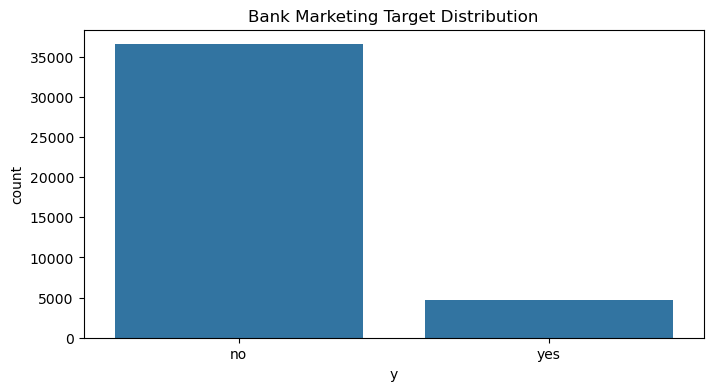

/Users/LeeChung/anaconda3/envs/ml_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

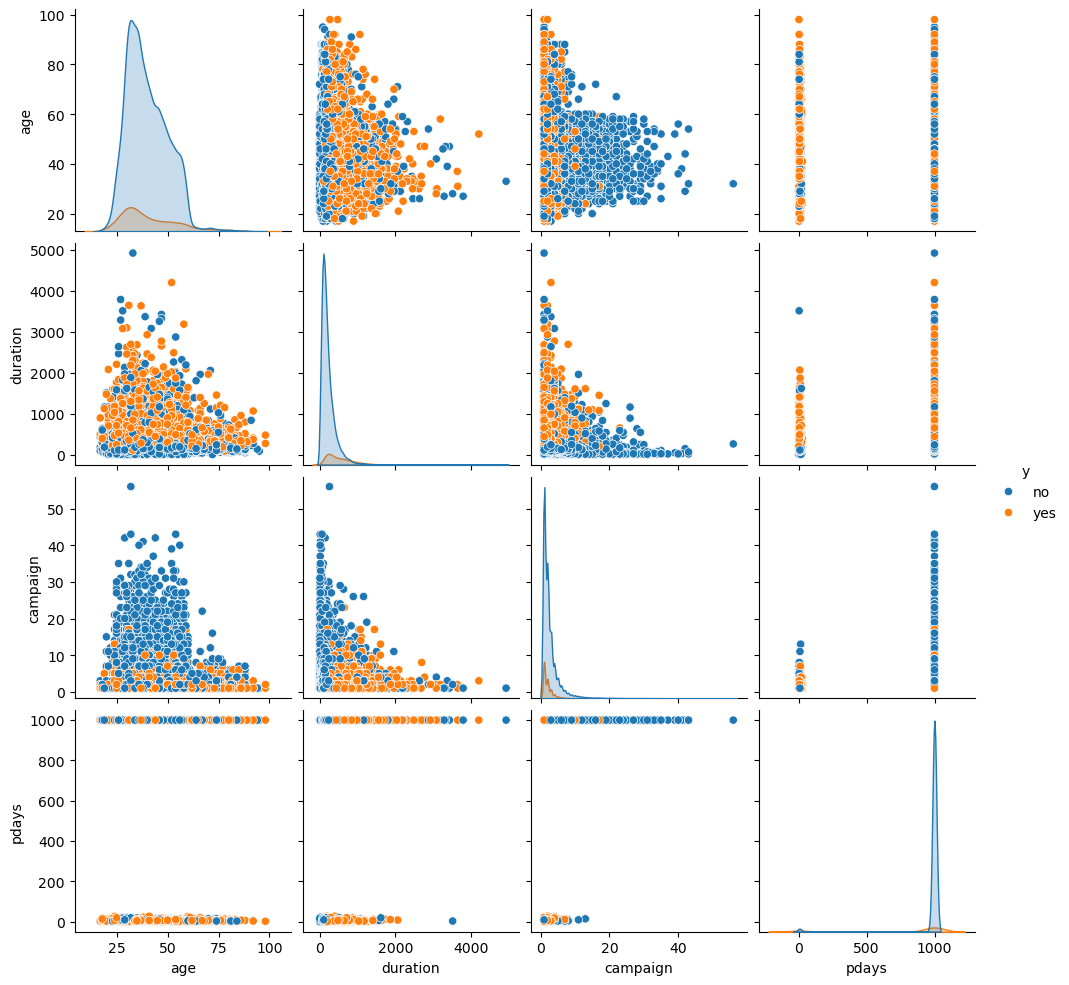

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 直接从本地文件加载
df = pd.read_csv('bank-additional-full.csv', sep=';')
X = df.drop('y', axis=1)
y = df['y']

# 定义类别名称
class_names = ['no', 'yes']

# 查看数据基本信息
print("数据集形状:", X.shape)
print("\n特征名称:", X.columns.tolist())
print("\n目标类别:", class_names)
print("\n数据集前5行:")
print(X.head())

# 查看数据集的类别分布
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title('Bank Marketing Target Distribution')
plt.show()

# 查看部分重要特征之间的关系
selected_features = X.select_dtypes(include=['int64','float64']).columns[:4] # 选择前4个数值型特征
plot_data = pd.concat([X[selected_features], y], axis=1)
plt.figure(figsize=(10, 6))
sns.pairplot(plot_data, hue='y')
plt.show()

## 划分数据集

训练集大小: (32950, 20)
测试集大小: (8238, 20)

训练集类别分布:
0    29238
1     3712
Name: count, dtype: int64

测试集类别分布:
0    7310
1     928
Name: count, dtype: int64


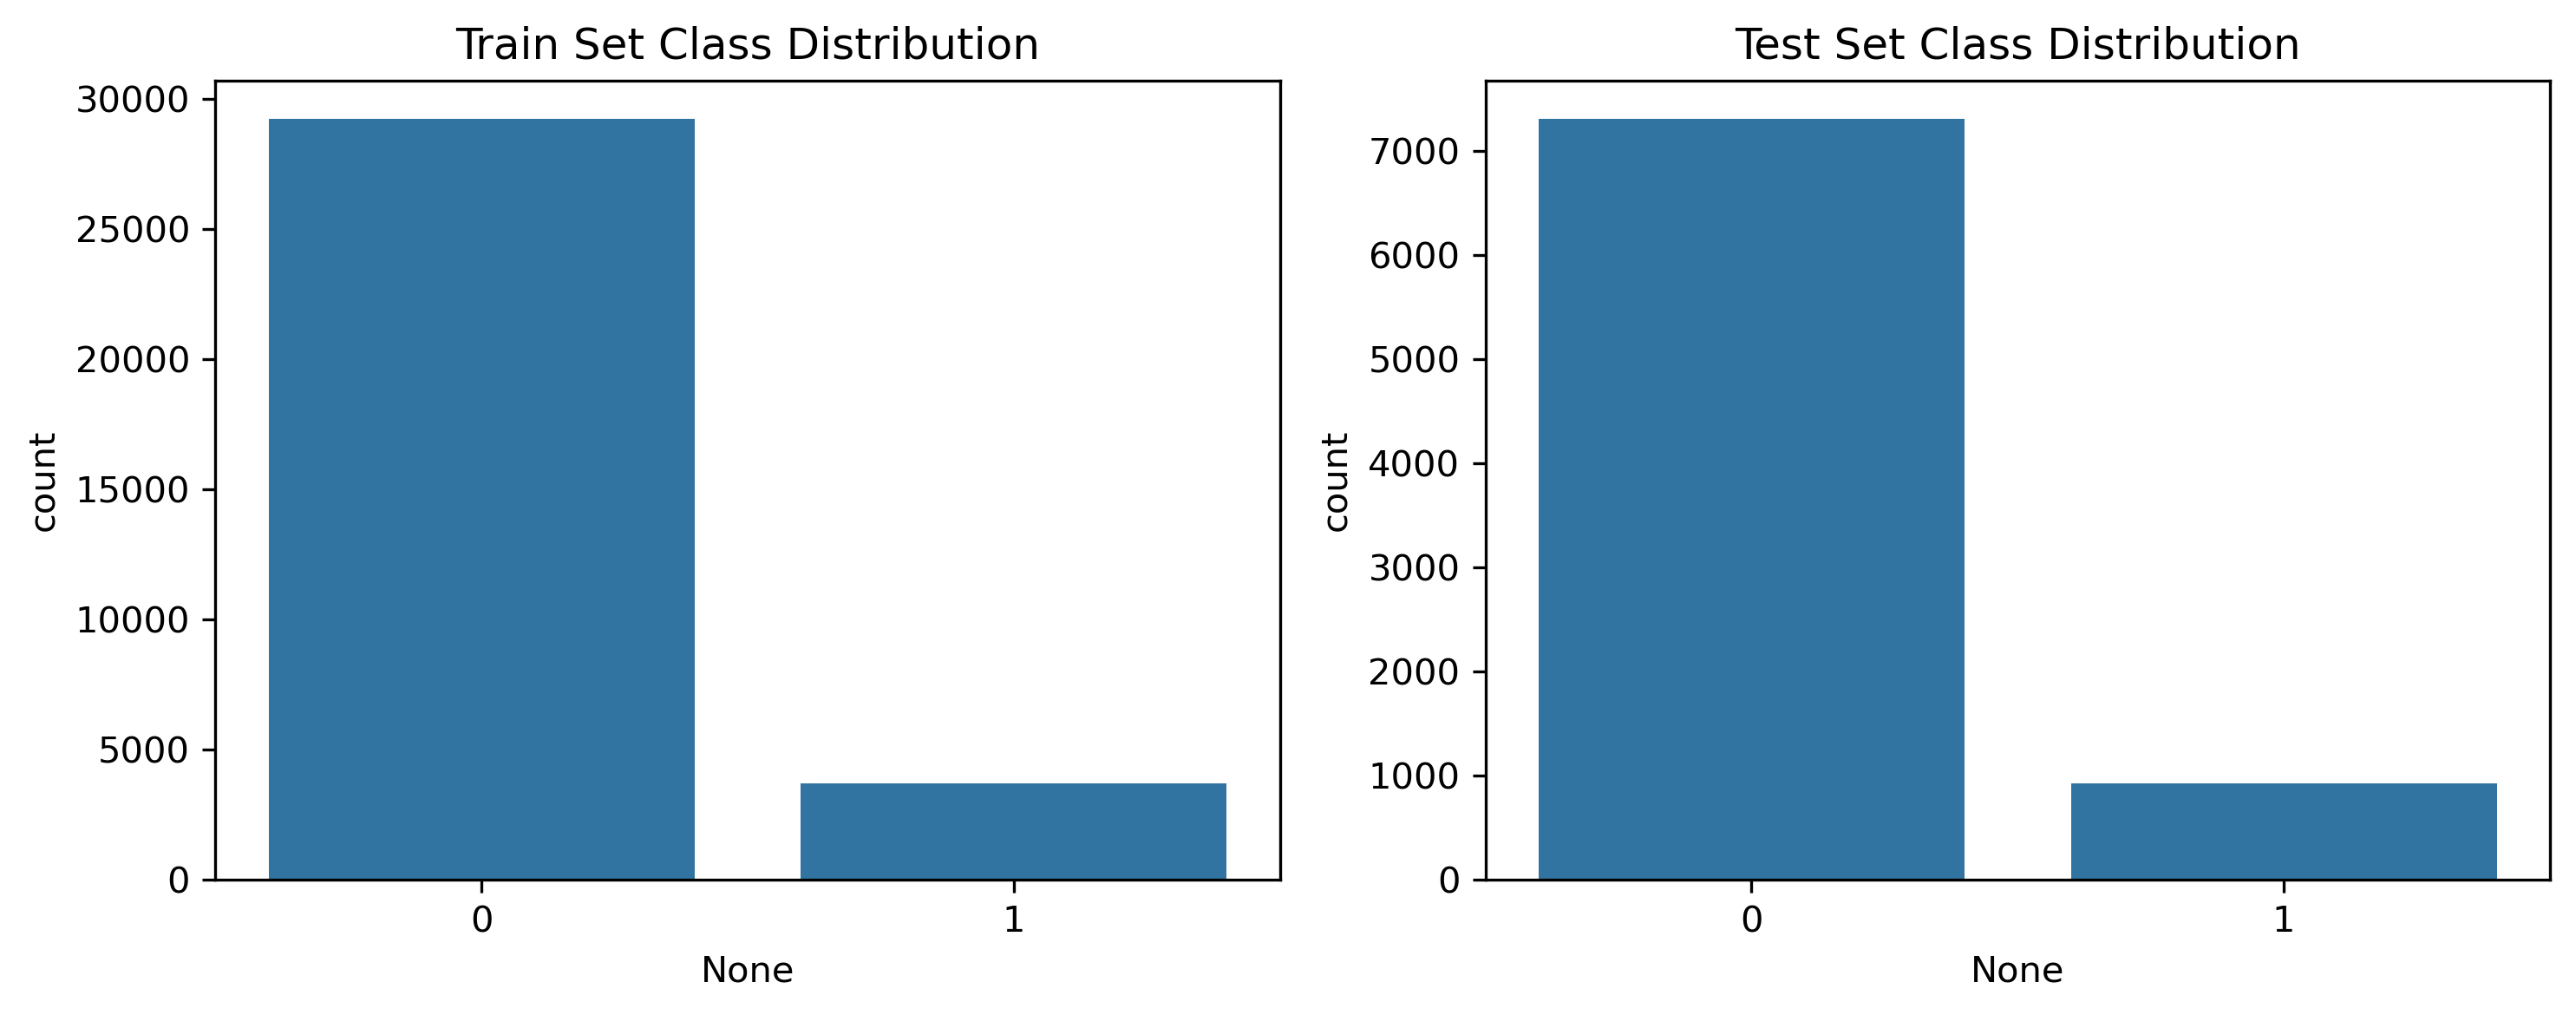

In [31]:
# 在创建随机森林之前添加数据预处理代码
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE  # 改用SMOTE过采样


# 对分类特征进行编码
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# 确保y也是数值型
if isinstance(y, pd.DataFrame):
    y = y.iloc[:,0]  # 取第一列
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# 将y转换为numpy数组
y = np.array(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,      # 测试集占20%
    random_state=42,    # 设置随机种子，确保结果可复现
    stratify=y          # 保持分层抽样，确保训练集和测试集中类别比例一致
)

# # 创建欠采样器
# rus = RandomUnderSampler(random_state=42)

# # 对训练集进行欠采样
# X_train, y_train = rus.fit_resample(X_train, y_train)

# # 创建SMOTE过采样器
# smote = SMOTE(random_state=42)

# # 对训练集进行过采样
# X_train, y_train = smote.fit_resample(X_train, y_train)

# 打印数据集大小
print("训练集大小:", X_train.shape)
print("测试集大小:", X_test.shape)

# 检查类别分布是否均衡
print("\n训练集类别分布:")
print(pd.Series(y_train).value_counts())
print("\n测试集类别分布:")
print(pd.Series(y_test).value_counts())

# 可视化训练集和测试集的类别分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),dpi = 300)

# 使用Series进行可视化
sns.countplot(x=pd.Series(y_train), ax=ax1)
ax1.set_title('Train Set Class Distribution')

sns.countplot(x=pd.Series(y_test), ax=ax2)
ax2.set_title('Test Set Class Distribution')

plt.tight_layout()
plt.show()

## 基础随机森林模型

训练集评估结果：
--------------------------------------------------
准确率: 0.9407587253414263

分类报告:
              precision    recall  f1-score   support

          no       0.95      0.99      0.97     29238
         yes       0.86      0.57      0.68      3712

    accuracy                           0.94     32950
   macro avg       0.90      0.78      0.83     32950
weighted avg       0.94      0.94      0.94     32950


测试集评估结果：
--------------------------------------------------
准确率: 0.9214615197863559

分类报告:
              precision    recall  f1-score   support

          no       0.93      0.98      0.96      7310
         yes       0.74      0.46      0.57       928

    accuracy                           0.92      8238
   macro avg       0.84      0.72      0.76      8238
weighted avg       0.91      0.92      0.91      8238



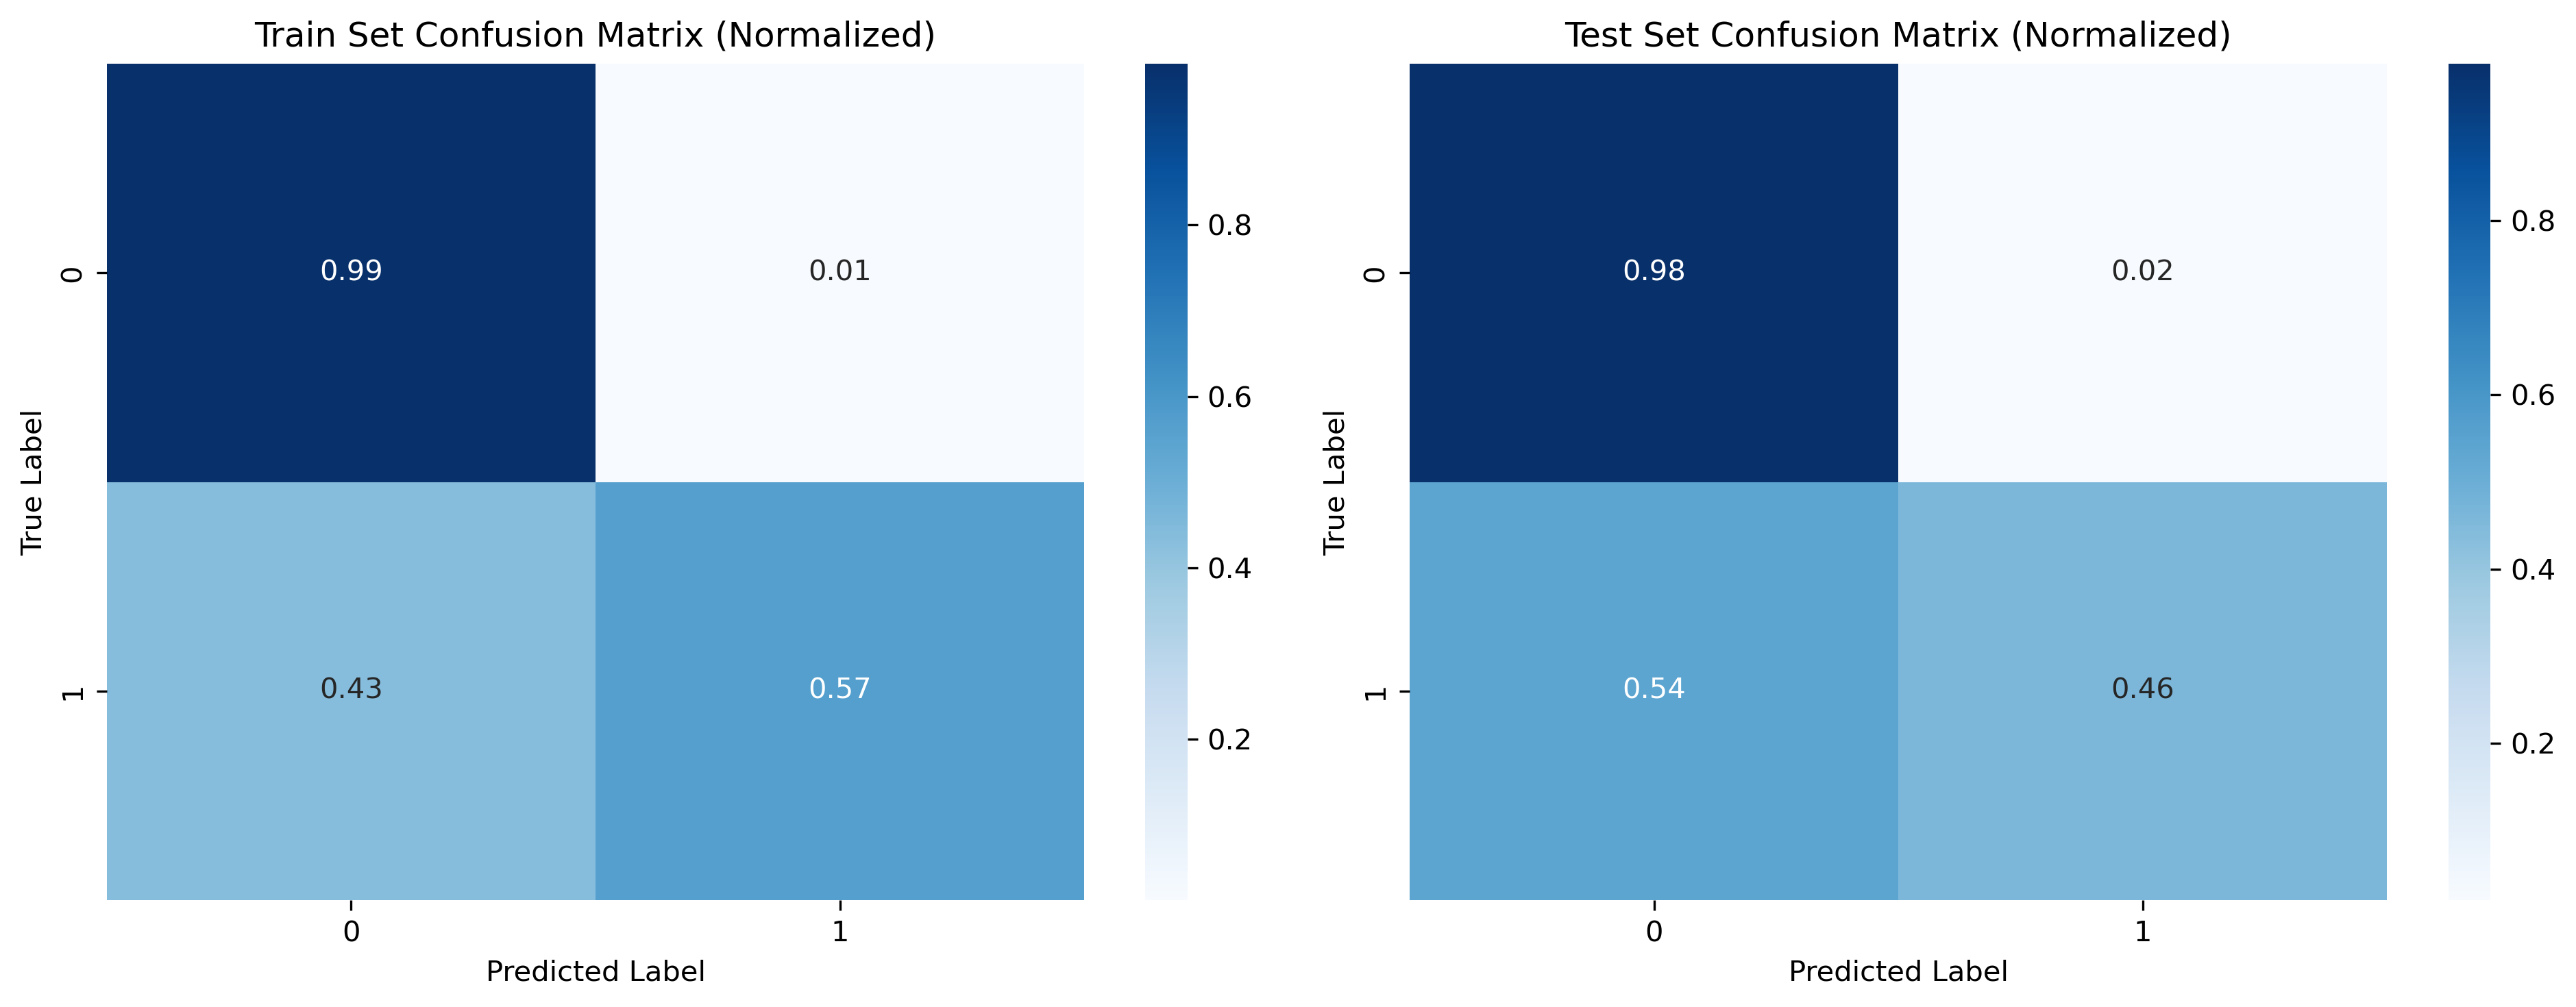

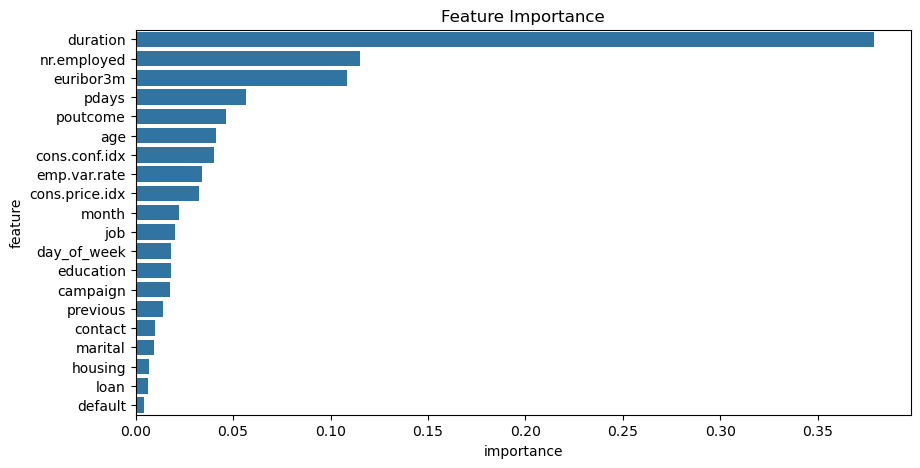

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 创建随机森林分类器
rf = RandomForestClassifier(
    n_estimators=140,        # 决策树数量
    max_depth=10,            # 树的最大深度
    max_samples=0.8,        # 训练单棵树时使用的样本比例
    bootstrap=True,         # 是否使用放回抽样
    random_state=42         # 随机种子
)

# 训练模型
rf.fit(X_train, y_train)

# 在训练集和测试集上进行预测
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# 定义类别名称
class_names = ['no', 'yes']  # 因为是二分类问题，所以手动定义类别名称

# 输出模型评估结果
print("="*50)
print("训练集评估结果：")
print("-"*50)
print("准确率:", rf.score(X_train, y_train))
print("\n分类报告:")
print(classification_report(y_train, y_train_pred, target_names=class_names))

print("\n测试集评估结果：")
print("-"*50)
print("准确率:", rf.score(X_test, y_test))
print("\n分类报告:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# ...其余代码保持不变...
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

# 训练集混淆矩阵
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_train_norm, annot=True, fmt='.2f', ax=ax1, cmap='Blues')
ax1.set_title('Train Set Confusion Matrix (Normalized)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 测试集混淆矩阵
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt='.2f', ax=ax2, cmap='Blues')
ax2.set_title('Test Set Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# 输出特征重要性
feature_importance = pd.DataFrame({
    'feature': X.columns.tolist(),
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## 网格搜索最佳参数

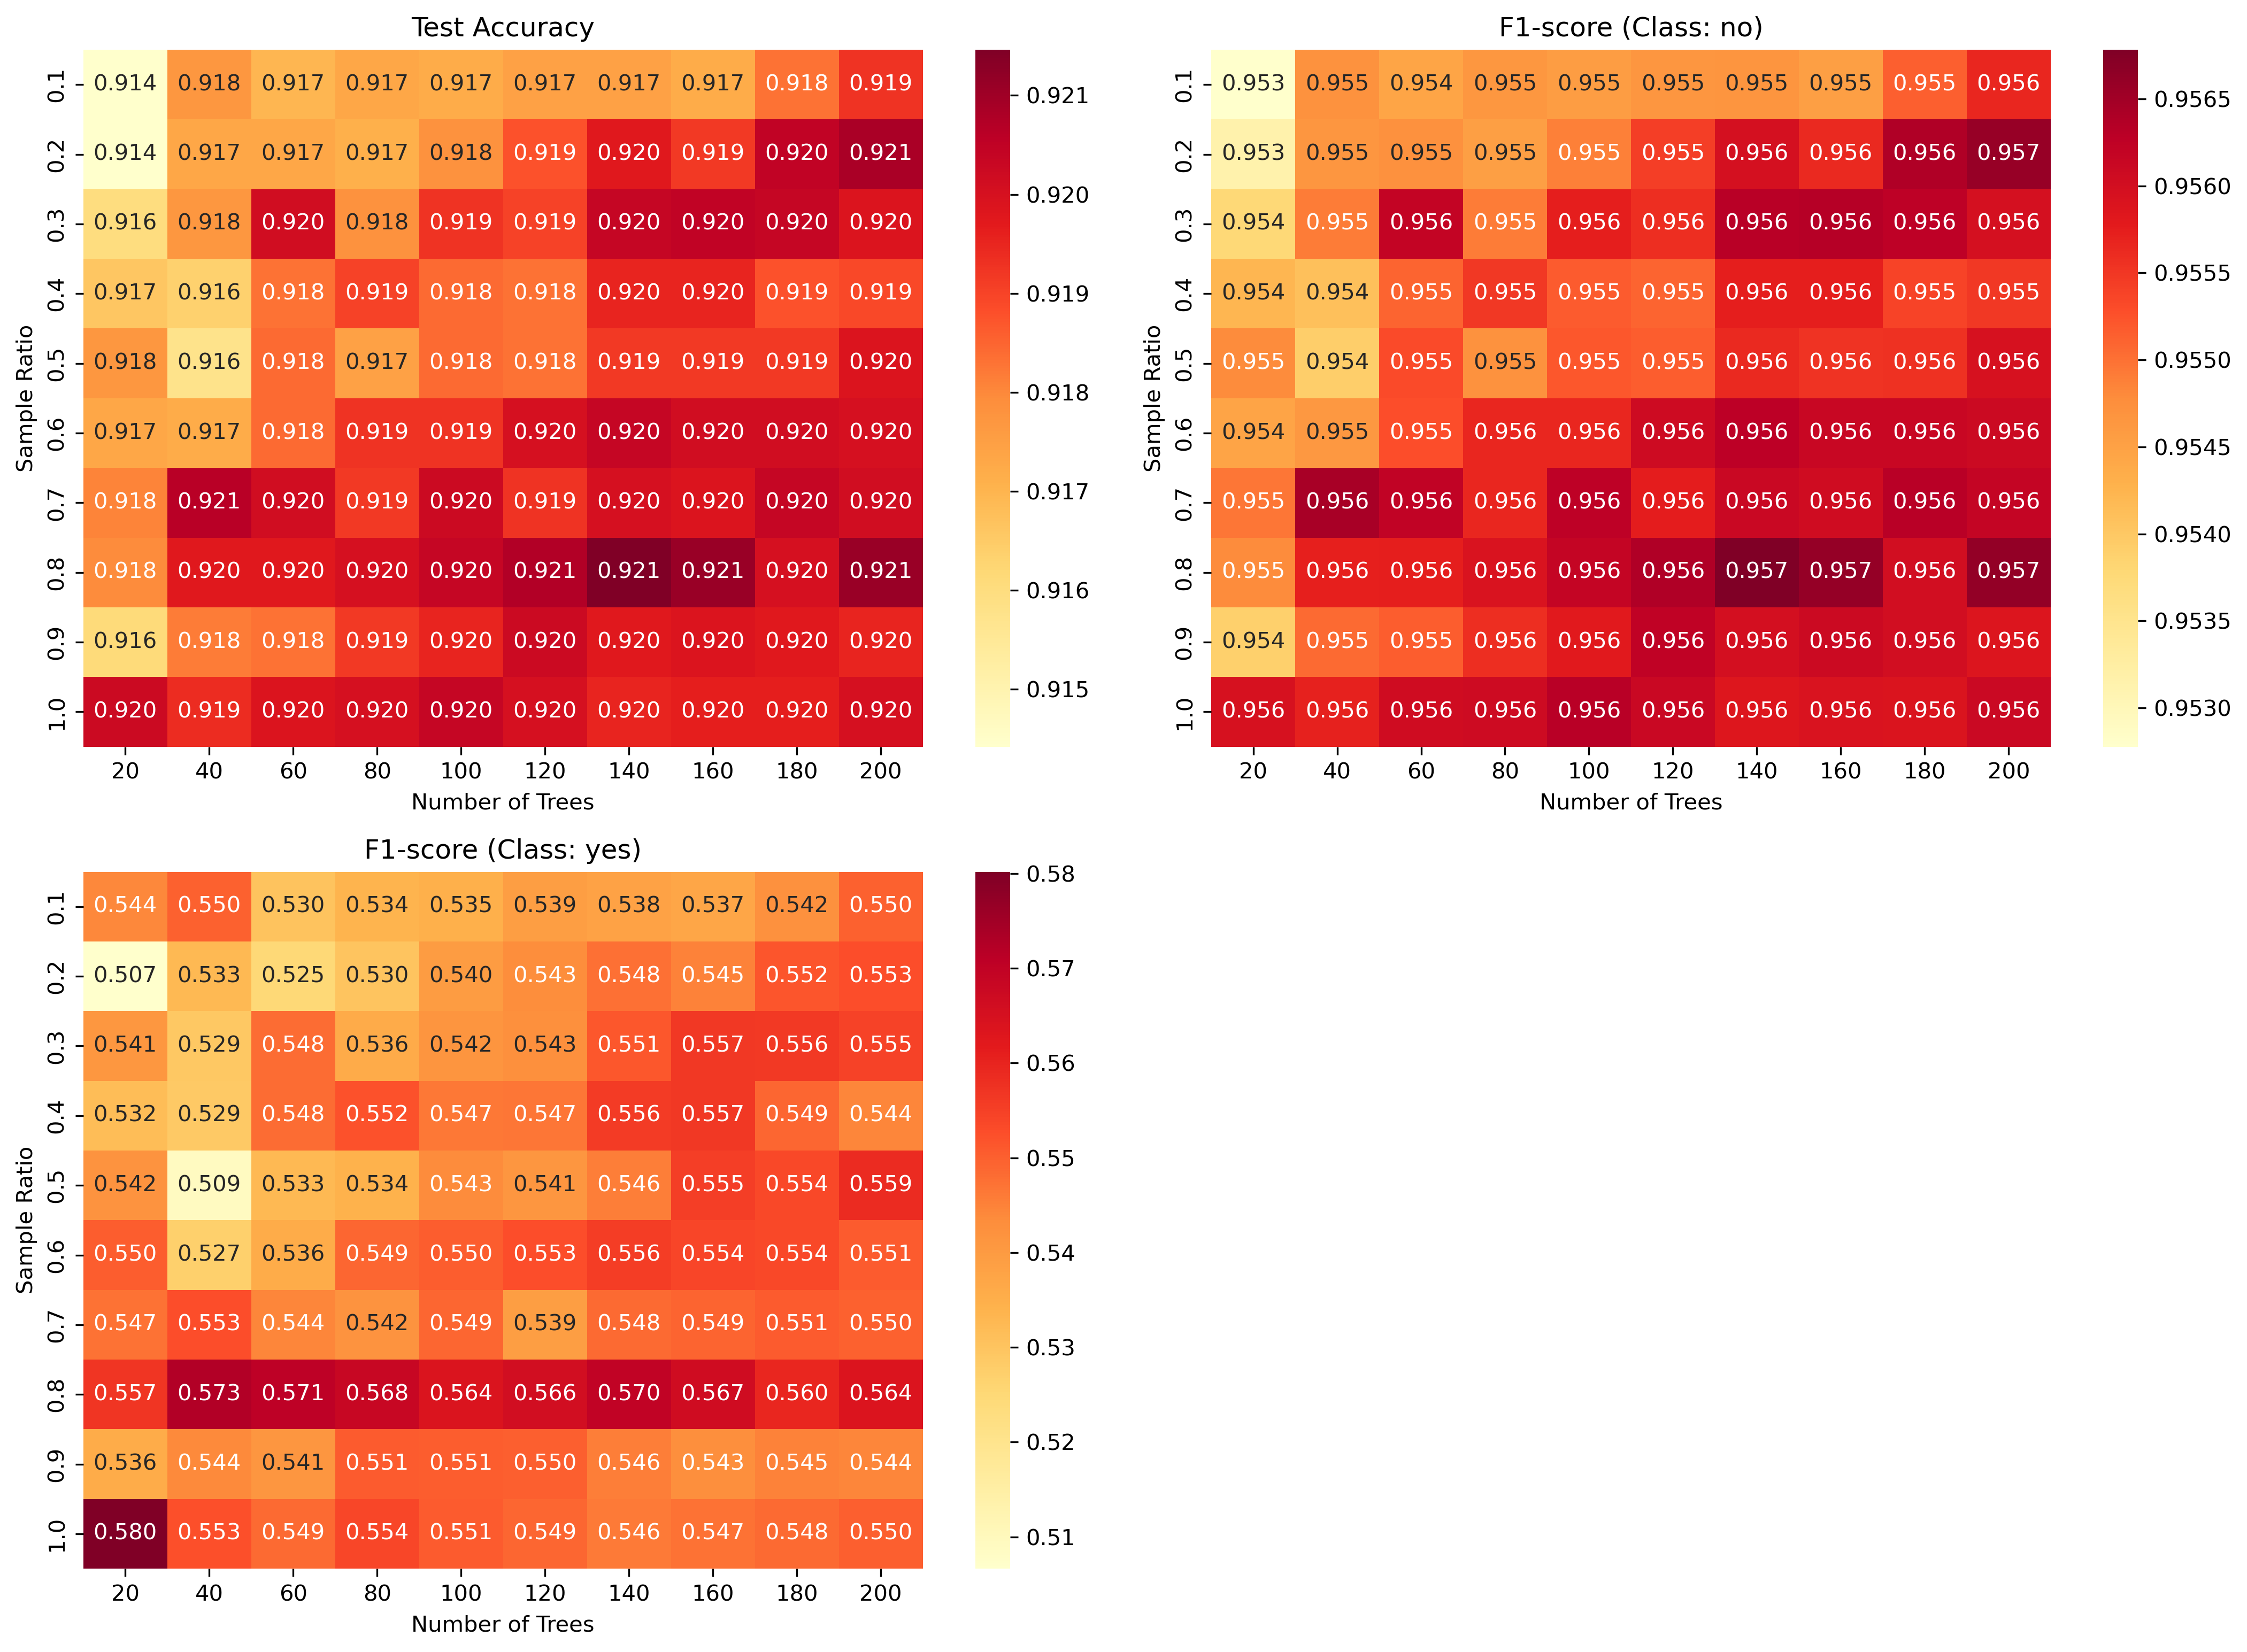


最佳参数组合：
Sample Ratio: 0.8
Number of Trees: 140.0
Test Accuracy: 0.9215

每个类别在最佳参数下的性能：

no:
Precision: 0.9349
Recall: 0.9798
F1-score: 0.9568

yes:
Precision: 0.7435
Recall: 0.4623
F1-score: 0.5701


In [23]:
# 定义两个维度的参数范围
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_estimators_range = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# 创建结果字典
results = {
    'sample_ratio': [],
    'n_estimators': [],
    'test_accuracy': []
}

# 为每个类别添加指标
class_names = ['no', 'yes']
for class_name in class_names:
    results[f'test_precision_{class_name}'] = []
    results[f'test_recall_{class_name}'] = []
    results[f'test_f1_{class_name}'] = []

# 进行网格搜索
for ratio in sample_ratios:
    for n_trees in n_estimators_range:
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_samples=ratio,
            max_depth=10,
            random_state=42,
            bootstrap=True
        )
        
        # 训练模型
        rf.fit(X_train, y_train)
        
        # 预测
        y_test_pred = rf.predict(X_test)
        
        # 计算指标
        test_report = classification_report(y_test, y_test_pred, 
                                          target_names=class_names, 
                                          output_dict=True)
        
        # 存储结果
        results['sample_ratio'].append(ratio)
        results['n_estimators'].append(n_trees)
        results['test_accuracy'].append(rf.score(X_test, y_test))
        
        # 存储每个类别的指标
        for class_name in class_names:
            results[f'test_precision_{class_name}'].append(test_report[class_name]['precision'])
            results[f'test_recall_{class_name}'].append(test_report[class_name]['recall'])
            results[f'test_f1_{class_name}'].append(test_report[class_name]['f1-score'])

# ...现有代码保持不变直到 DataFrame 转换部分...

# 转换为DataFrame并创建热力图
results_df = pd.DataFrame(results)

# 创建热力图
plt.figure(figsize=(11*1.3, 8*1.3), dpi=300)

# 准确率热力图
accuracy_pivot = pd.pivot_table(
    data=results_df,
    values='test_accuracy',
    index='sample_ratio',
    columns='n_estimators'
)

plt.subplot(2, 2, 1)
sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Sample Ratio')

# 对每个类别绘制F1-score热力图
for i, class_name in enumerate(class_names, 2):
    f1_pivot = pd.pivot_table(
        data=results_df,
        values=f'test_f1_{class_name}',
        index='sample_ratio',
        columns='n_estimators'
    )
    plt.subplot(2, 2, i)
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title(f'F1-score (Class: {class_name})')
    plt.xlabel('Number of Trees')
    plt.ylabel('Sample Ratio')

plt.tight_layout()
plt.show()

# ...其余代码保持不变...

# 找出最佳参数组合
best_idx = results_df['test_accuracy'].idxmax()
best_params = results_df.loc[best_idx]
print("\n最佳参数组合：")
print(f"Sample Ratio: {best_params['sample_ratio']}")
print(f"Number of Trees: {best_params['n_estimators']}")
print(f"Test Accuracy: {best_params['test_accuracy']:.4f}")

print("\n每个类别在最佳参数下的性能：")
for class_name in class_names:
    print(f"\n{class_name}:")
    print(f"Precision: {best_params[f'test_precision_{class_name}']:.4f}")
    print(f"Recall: {best_params[f'test_recall_{class_name}']:.4f}")
    print(f"F1-score: {best_params[f'test_f1_{class_name}']:.4f}")

## 研究不同抽样比例的影响（固定树的数量为50）

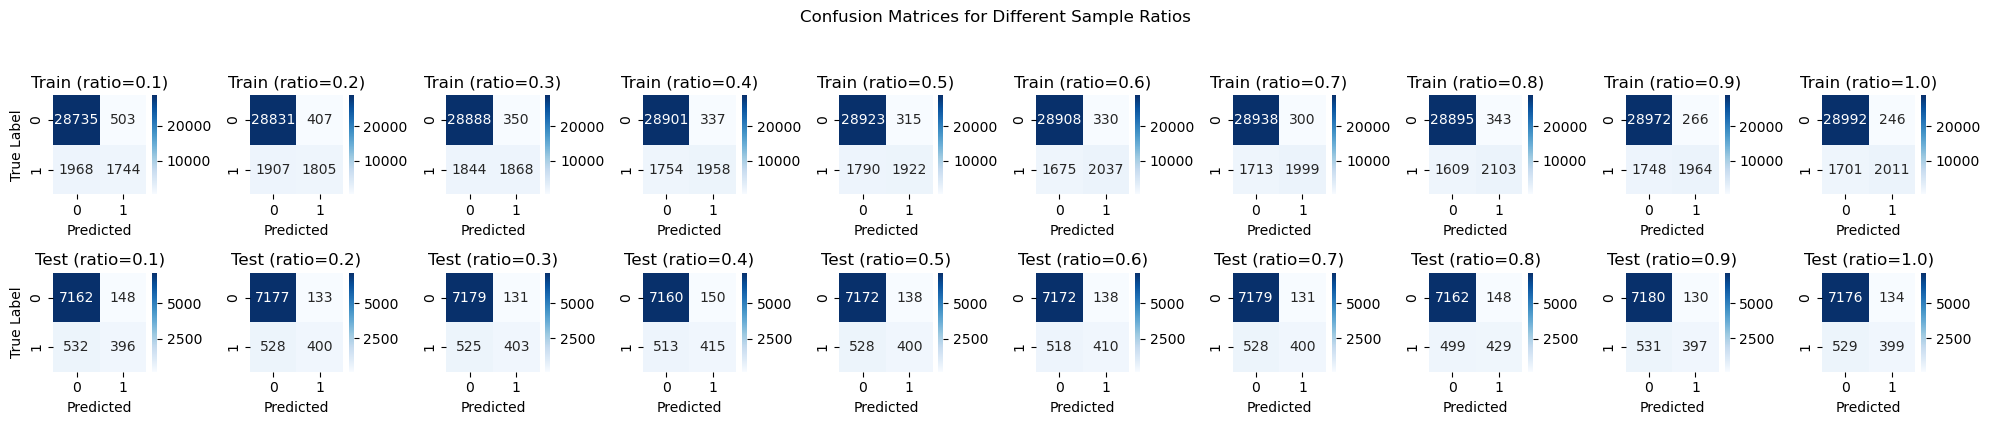

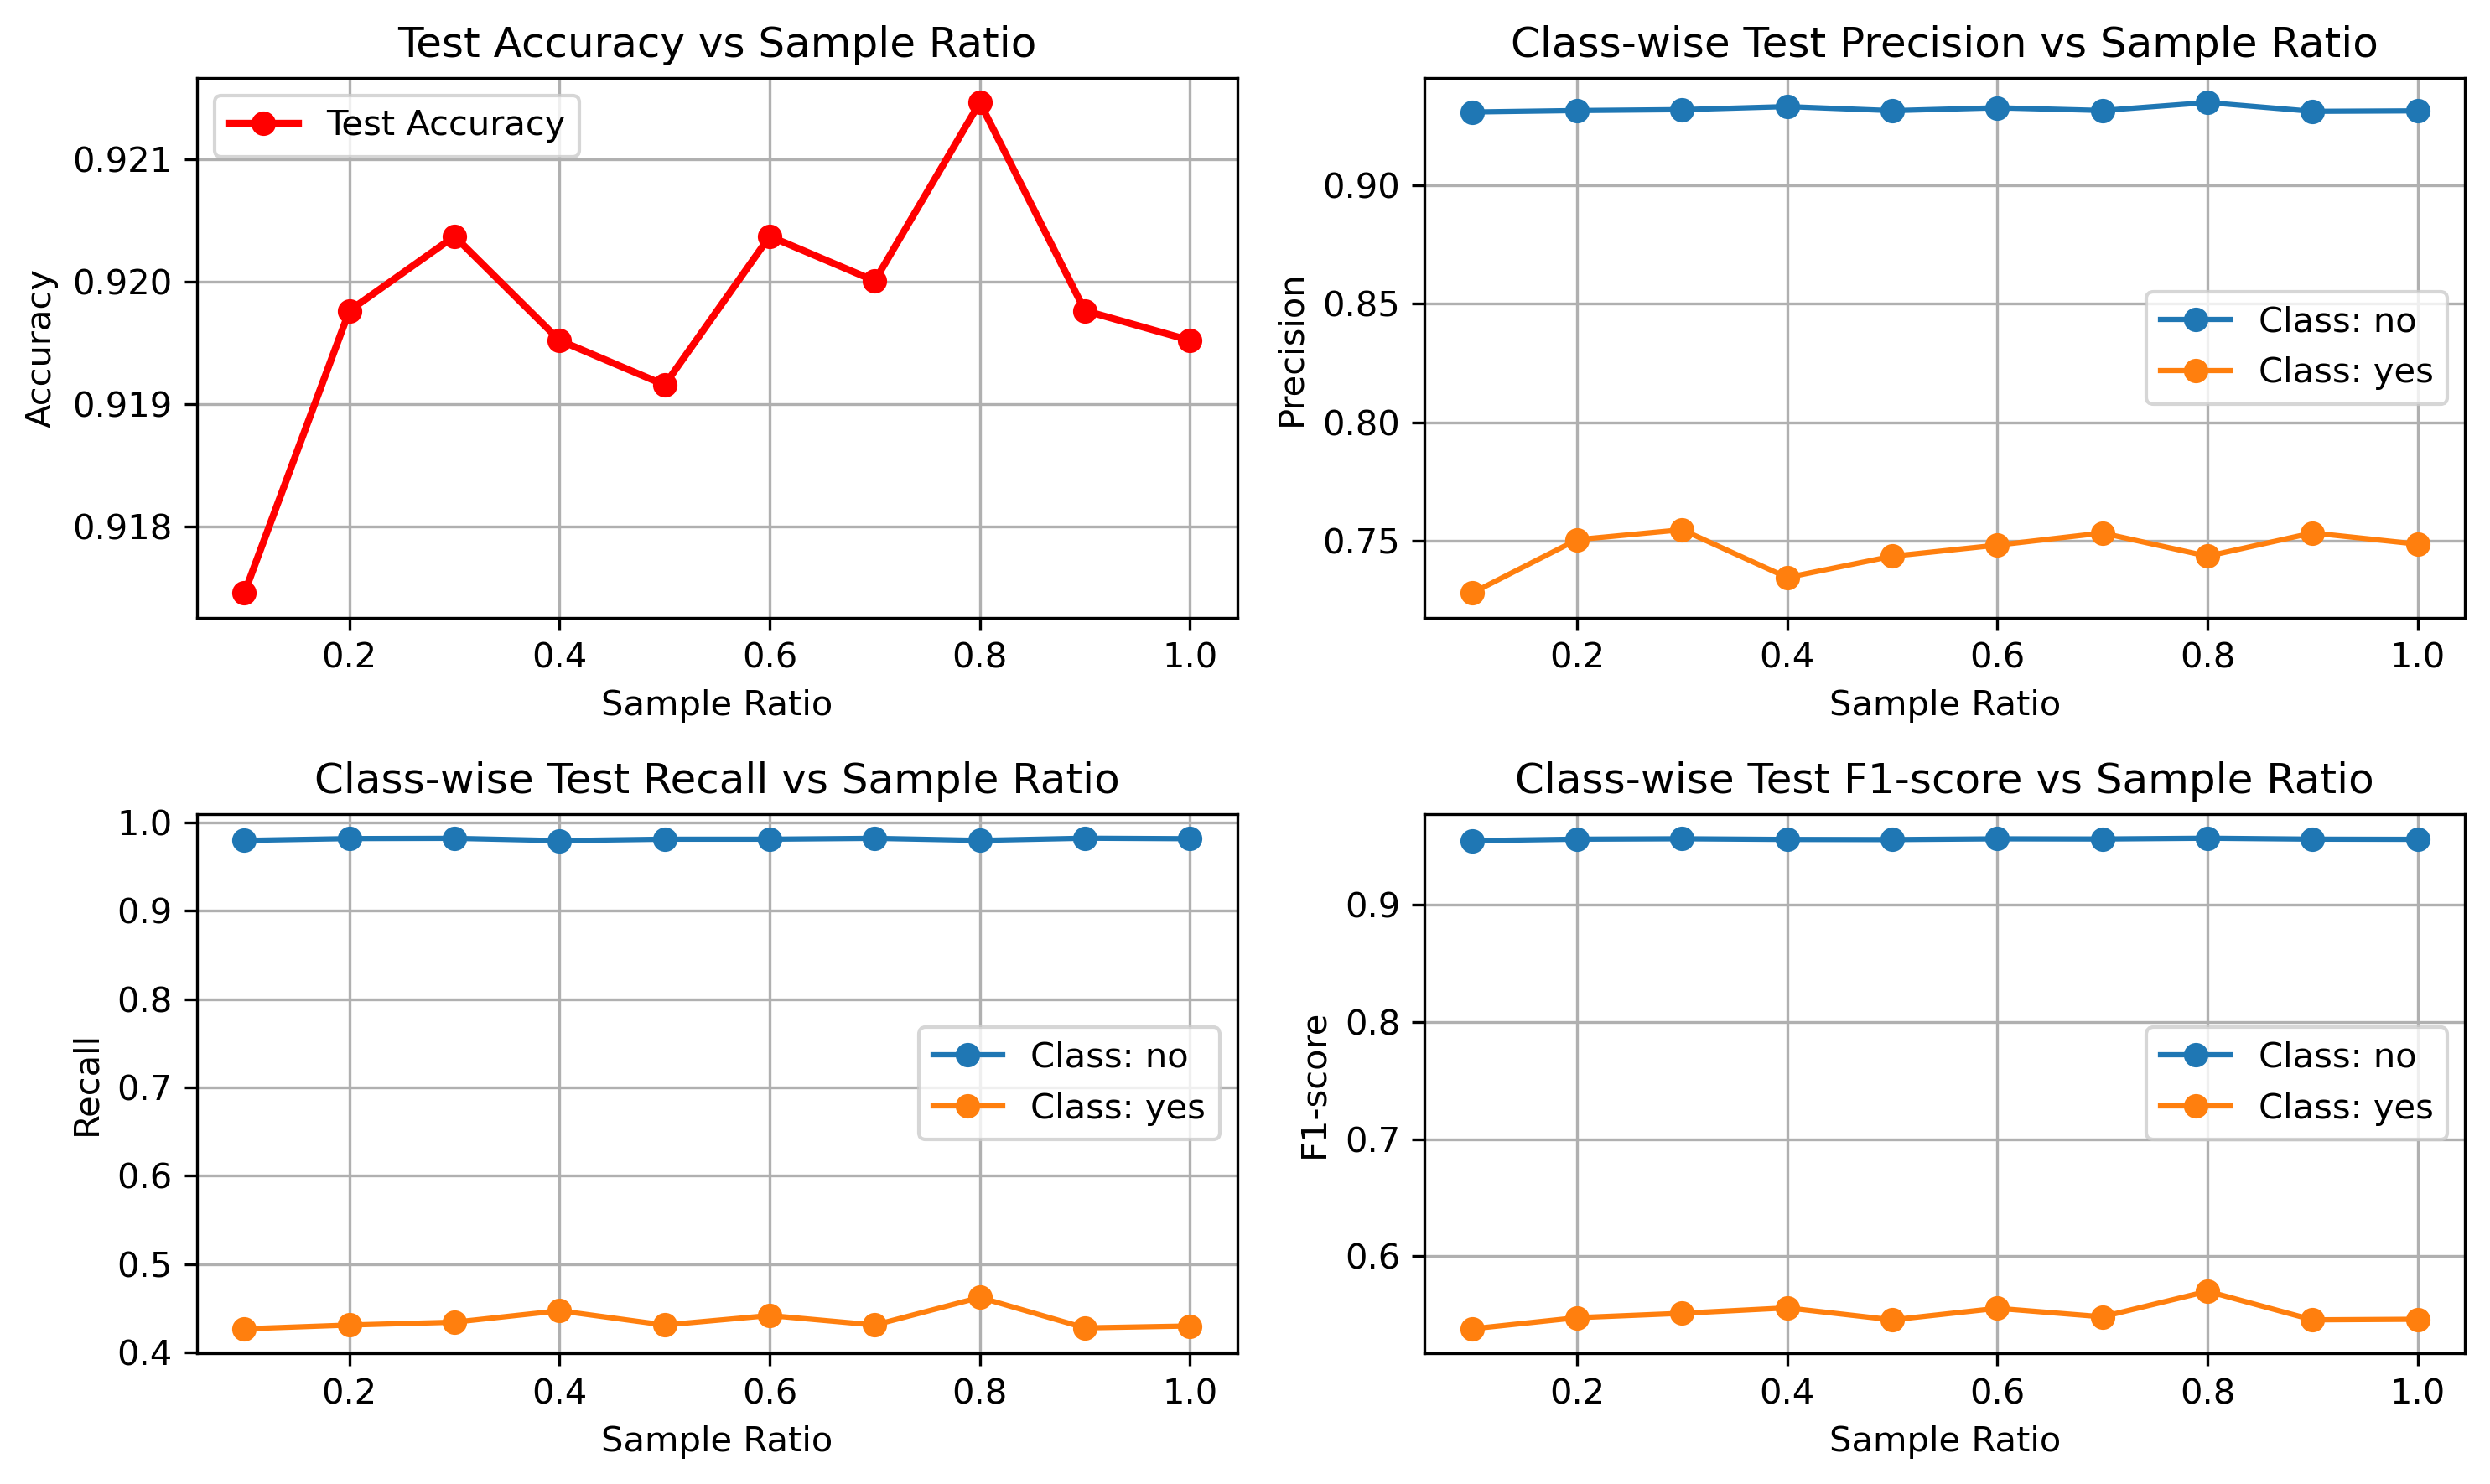


Best Sample Ratio: 0.8
Test Accuracy with Best Ratio: 0.9215

Class-wise Test Performance at Best Ratio:

no:
Precision: 0.9349
Recall: 0.9798
F1-score: 0.9568

yes:
Precision: 0.7435
Recall: 0.4623
F1-score: 0.5701


In [21]:
# 研究不同抽样比例的影响（固定树的数量为50）
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# 为每个类别创建结果字典
results = {
    'sample_ratio': [],
    'train_accuracy': [],
    'test_accuracy': []
}

# 为每个类别添加指标
class_names = ['no', 'yes'] 
for class_name in class_names:
    results[f'train_precision_{class_name}'] = []
    results[f'test_precision_{class_name}'] = []
    results[f'train_recall_{class_name}'] = []
    results[f'test_recall_{class_name}'] = []
    results[f'train_f1_{class_name}'] = []
    results[f'test_f1_{class_name}'] = []

# 创建一个大图用于显示所有混淆矩阵
plt.figure(figsize=(20, 4))
plt.suptitle('Confusion Matrices for Different Sample Ratios', y=1.05)

# 对每个抽样比例进行训练和测试
for idx, ratio in enumerate(sample_ratios):
    # 创建子图
    plt.subplot(2, len(sample_ratios), idx + 1)
    
    rf = RandomForestClassifier(
        n_estimators=140,    # 固定树的数量
        max_samples=ratio,  # 变化抽样比例
        max_depth=10,       # 保持与基础模型相同的树深度
        random_state=42,
        bootstrap=True
    )
    
    # 训练模型
    rf.fit(X_train, y_train)
    
    # 预测
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # 计算混淆矩阵
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # 绘制训练集混淆矩阵
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Train (ratio={ratio})')
    if idx == 0:
        plt.ylabel('True Label')
    plt.xlabel('Predicted')
    
    # 绘制测试集混淆矩阵
    plt.subplot(2, len(sample_ratios), idx + len(sample_ratios) + 1)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test (ratio={ratio})')
    if idx == 0:
        plt.ylabel('True Label')
    plt.xlabel('Predicted')
    
    # 计算各项指标
    train_report = classification_report(y_train, y_train_pred, 
                                       target_names=class_names, 
                                       output_dict=True)
    test_report = classification_report(y_test, y_test_pred, 
                                      target_names=class_names, 
                                      output_dict=True)
    
    # 存储基本结果
    results['sample_ratio'].append(ratio)
    results['train_accuracy'].append(rf.score(X_train, y_train))
    results['test_accuracy'].append(rf.score(X_test, y_test))
    
    # 存储每个类别的详细指标
    for class_name in class_names:
        results[f'train_precision_{class_name}'].append(train_report[class_name]['precision'])
        results[f'test_precision_{class_name}'].append(test_report[class_name]['precision'])
        results[f'train_recall_{class_name}'].append(train_report[class_name]['recall'])
        results[f'test_recall_{class_name}'].append(test_report[class_name]['recall'])
        results[f'train_f1_{class_name}'].append(train_report[class_name]['f1-score'])
        results[f'test_f1_{class_name}'].append(test_report[class_name]['f1-score'])

plt.tight_layout()
plt.show()

# 转换为DataFrame并绘制性能指标图
results_df = pd.DataFrame(results)

# 绘制性能指标图
plt.figure(figsize=(10, 6), dpi=300)

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(results_df['sample_ratio'], results_df['test_accuracy'], 
         marker='o', label='Test Accuracy', linewidth=2, color='red')
plt.xlabel('Sample Ratio')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Sample Ratio')
plt.grid(True)
plt.legend()

# Precision
plt.subplot(2, 2, 2)
for class_name in class_names:
    plt.plot(results_df['sample_ratio'], results_df[f'test_precision_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Sample Ratio')
plt.ylabel('Precision')
plt.title('Class-wise Test Precision vs Sample Ratio')
plt.grid(True)
plt.legend()

# Recall
plt.subplot(2, 2, 3)
for class_name in class_names:
    plt.plot(results_df['sample_ratio'], results_df[f'test_recall_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Sample Ratio')
plt.ylabel('Recall')
plt.title('Class-wise Test Recall vs Sample Ratio')
plt.grid(True)
plt.legend()

# F1-score
plt.subplot(2, 2, 4)
for class_name in class_names:
    plt.plot(results_df['sample_ratio'], results_df[f'test_f1_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Sample Ratio')
plt.ylabel('F1-score')
plt.title('Class-wise Test F1-score vs Sample Ratio')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 打印最佳抽样比例及其性能
best_idx = results_df['test_accuracy'].idxmax()
best_ratio = results_df.loc[best_idx, 'sample_ratio']
print(f"\nBest Sample Ratio: {best_ratio}")
print(f"Test Accuracy with Best Ratio: {results_df.loc[best_idx, 'test_accuracy']:.4f}")

# 打印每个类别在最佳比例下的性能
print("\nClass-wise Test Performance at Best Ratio:")
for class_name in class_names:
    print(f"\n{class_name}:")
    print(f"Precision: {results_df.loc[best_idx, f'test_precision_{class_name}']:.4f}")
    print(f"Recall: {results_df.loc[best_idx, f'test_recall_{class_name}']:.4f}")
    print(f"F1-score: {results_df.loc[best_idx, f'test_f1_{class_name}']:.4f}")

## 研究不同树的数量的影响（固定抽样比例为0.6）

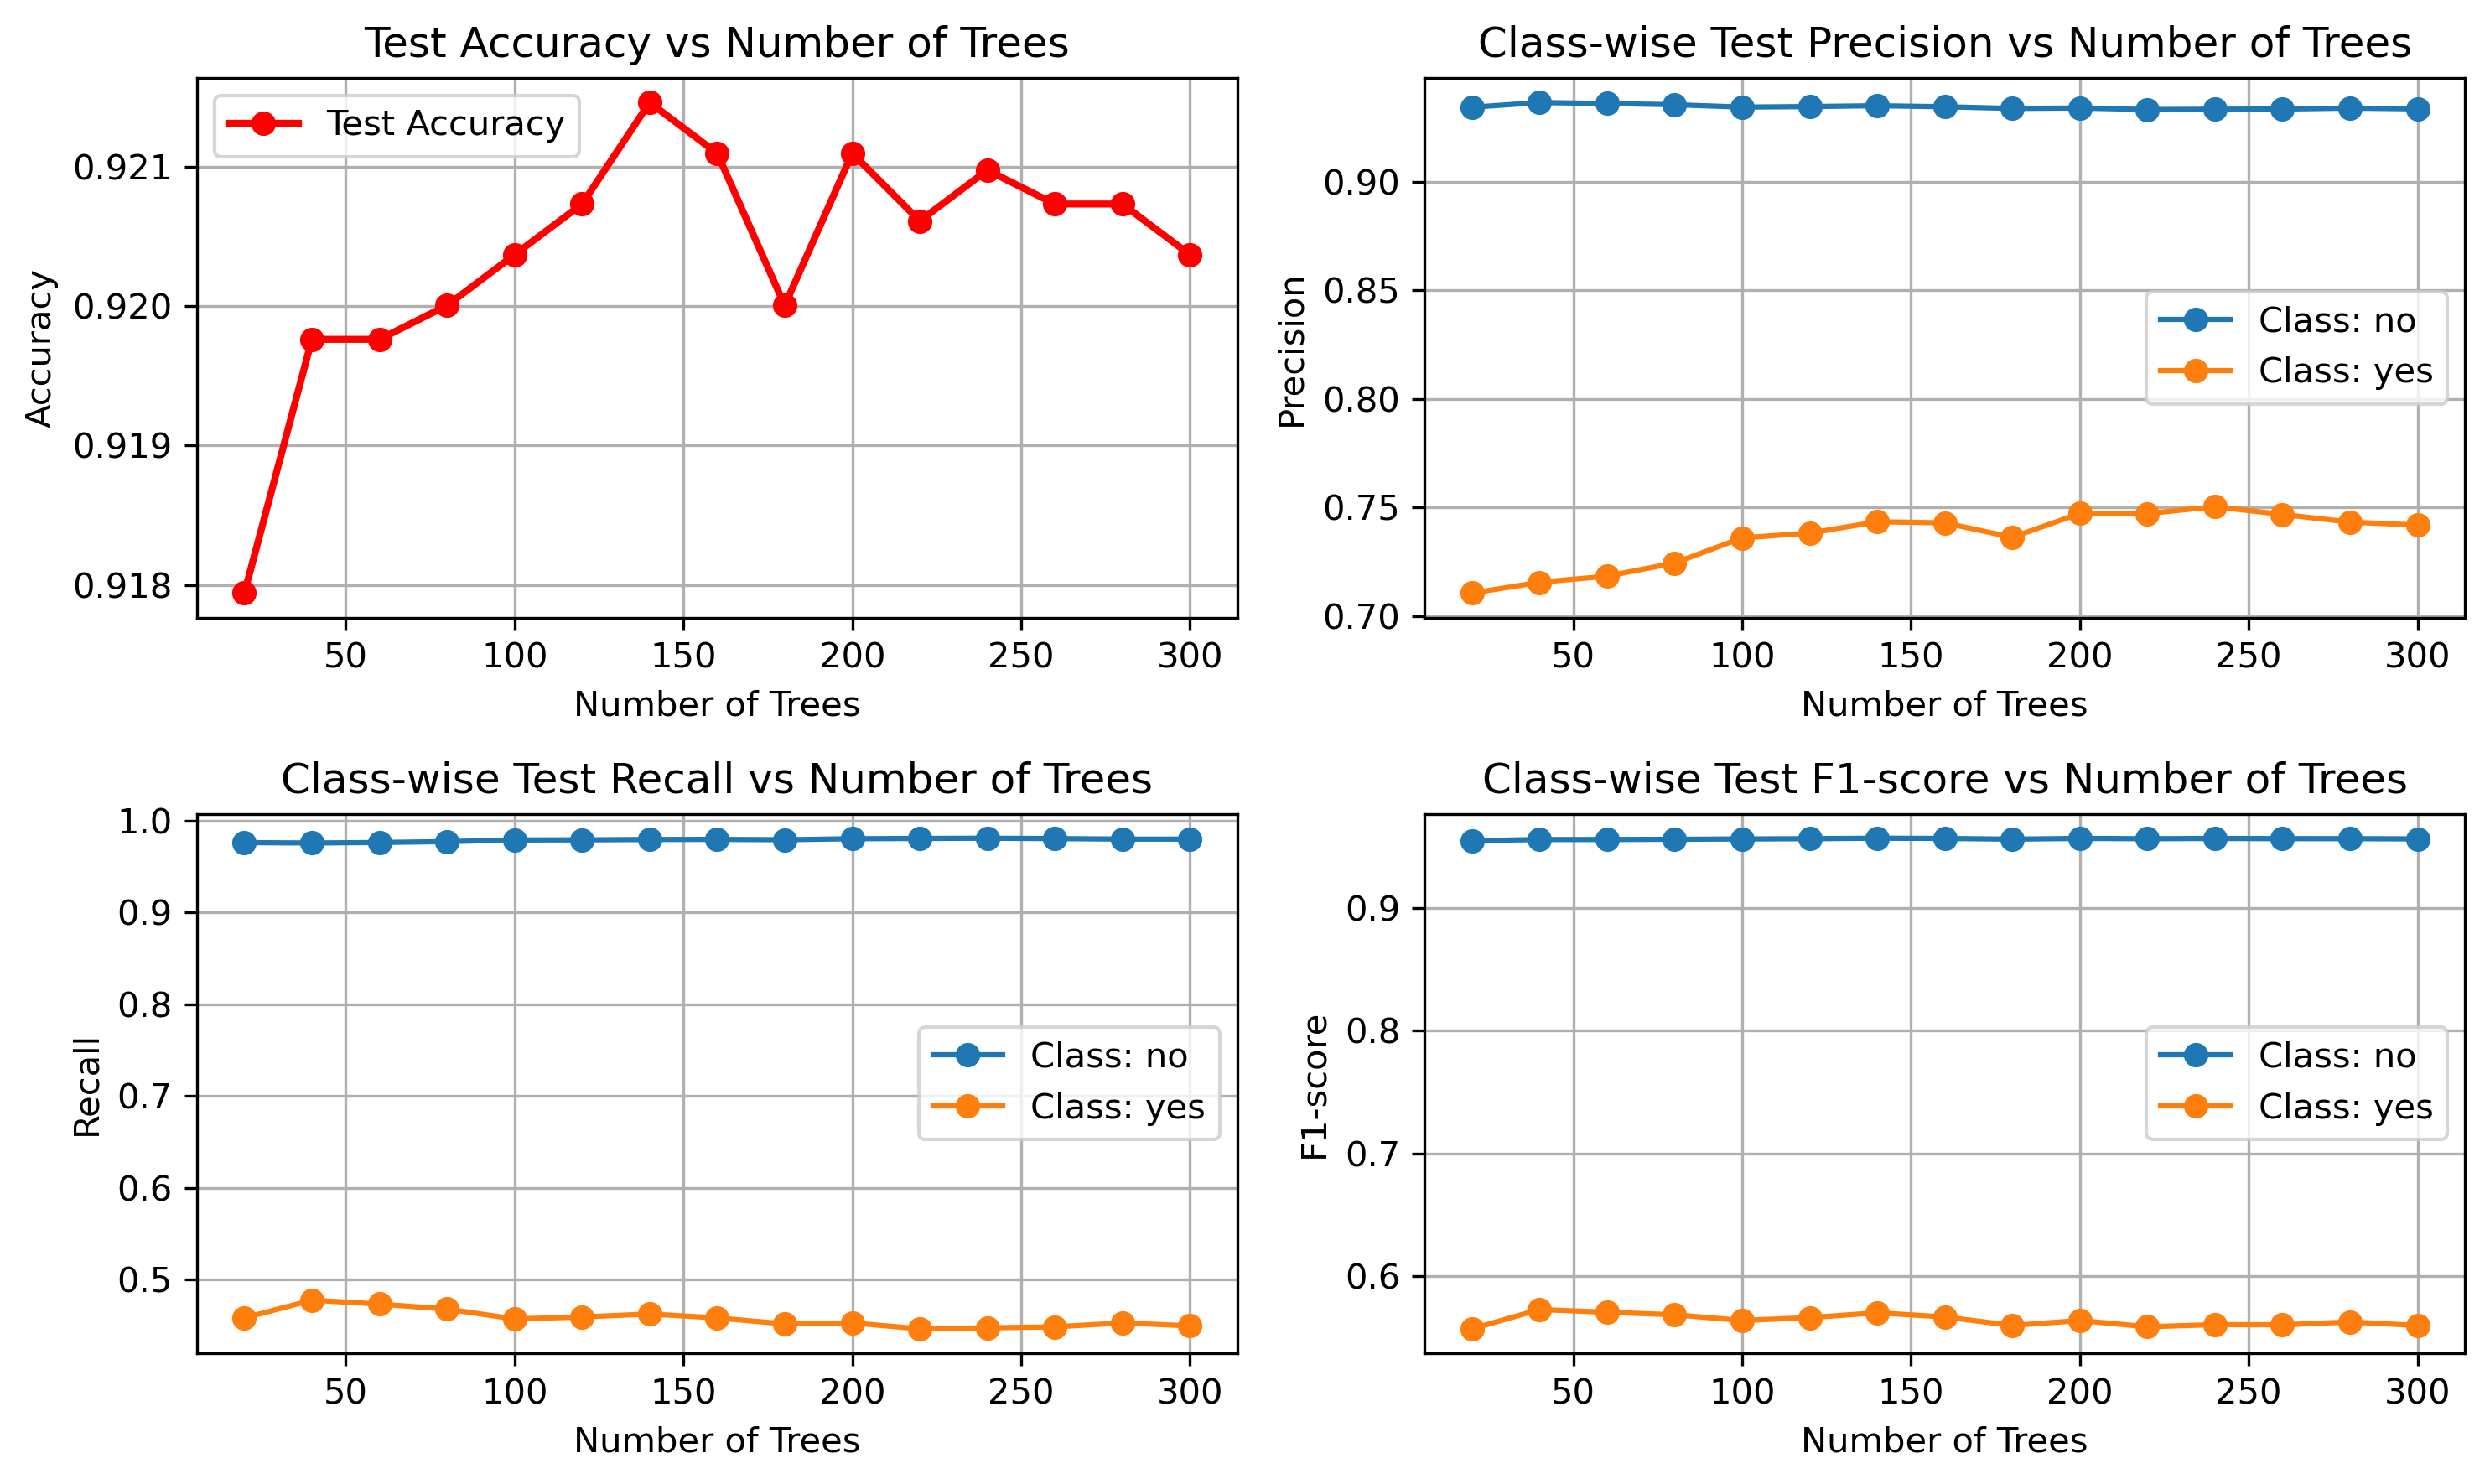


Best Number of Trees: 140
Test Accuracy with Best Trees: 0.9215

Class-wise Test Performance at Best Number of Trees:

no:
Precision: 0.9349
Recall: 0.9798
F1-score: 0.9568

yes:
Precision: 0.7435
Recall: 0.4623
F1-score: 0.5701


In [11]:
# 研究不同树的数量的影响（固定抽样比例为0.6）
n_estimators_range = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]

# 为每个类别创建结果字典
results = {
    'n_estimators': [],
    'train_accuracy': [],
    'test_accuracy': []
}

class_names = ['no', 'yes'] 
# 为每个类别添加指标
for class_name in class_names:
    results[f'train_precision_{class_name}'] = []
    results[f'test_precision_{class_name}'] = []
    results[f'train_recall_{class_name}'] = []
    results[f'test_recall_{class_name}'] = []
    results[f'train_f1_{class_name}'] = []
    results[f'test_f1_{class_name}'] = []

# 对每个树的数量进行训练和测试
for n_trees in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n_trees,  # 变化树的数量
        max_samples=0.8,       # 固定抽样比例
        max_depth=10,           # 保持与基础模型相同的树深度
        random_state=42,
        bootstrap=True
    )
    
    # 训练模型
    rf.fit(X_train, y_train)
    
    # 预测
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # 计算各项指标
    train_report = classification_report(y_train, y_train_pred, 
                                       target_names=class_names, 
                                       output_dict=True)
    test_report = classification_report(y_test, y_test_pred, 
                                      target_names=class_names, 
                                      output_dict=True)
    
    # 存储基本结果
    results['n_estimators'].append(n_trees)
    results['train_accuracy'].append(rf.score(X_train, y_train))
    results['test_accuracy'].append(rf.score(X_test, y_test))
    
    # 存储每个类别的详细指标
    for class_name in class_names:
        results[f'train_precision_{class_name}'].append(train_report[class_name]['precision'])
        results[f'test_precision_{class_name}'].append(test_report[class_name]['precision'])
        results[f'train_recall_{class_name}'].append(train_report[class_name]['recall'])
        results[f'test_recall_{class_name}'].append(test_report[class_name]['recall'])
        results[f'train_f1_{class_name}'].append(train_report[class_name]['f1-score'])
        results[f'test_f1_{class_name}'].append(test_report[class_name]['f1-score'])

# 转换为DataFrame
results_df = pd.DataFrame(results)

# 绘制结果
plt.figure(figsize=(10, 6), dpi=300)

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['test_accuracy'], 
         marker='o', label='Test Accuracy', linewidth=2, color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Number of Trees')
plt.grid(True)
plt.legend()

# Precision
plt.subplot(2, 2, 2)
for class_name in class_names:
    plt.plot(results_df['n_estimators'], results_df[f'test_precision_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.title('Class-wise Test Precision vs Number of Trees')
plt.grid(True)
plt.legend()

# Recall
plt.subplot(2, 2, 3)
for class_name in class_names:
    plt.plot(results_df['n_estimators'], results_df[f'test_recall_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')
plt.title('Class-wise Test Recall vs Number of Trees')
plt.grid(True)
plt.legend()

# F1-score
plt.subplot(2, 2, 4)
for class_name in class_names:
    plt.plot(results_df['n_estimators'], results_df[f'test_f1_{class_name}'], 
             marker='o', label=f'Class: {class_name}')
plt.xlabel('Number of Trees')
plt.ylabel('F1-score')
plt.title('Class-wise Test F1-score vs Number of Trees')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 打印最佳树的数量及其性能
best_idx = results_df['test_accuracy'].idxmax()
best_n_trees = results_df.loc[best_idx, 'n_estimators']
print(f"\nBest Number of Trees: {best_n_trees}")
print(f"Test Accuracy with Best Trees: {results_df.loc[best_idx, 'test_accuracy']:.4f}")

# 打印每个类别在最佳树数量下的性能
print("\nClass-wise Test Performance at Best Number of Trees:")
for class_name in class_names:
    print(f"\n{class_name}:")
    print(f"Precision: {results_df.loc[best_idx, f'test_precision_{class_name}']:.4f}")
    print(f"Recall: {results_df.loc[best_idx, f'test_recall_{class_name}']:.4f}")
    print(f"F1-score: {results_df.loc[best_idx, f'test_f1_{class_name}']:.4f}")

## 单颗树情形vs随机森林

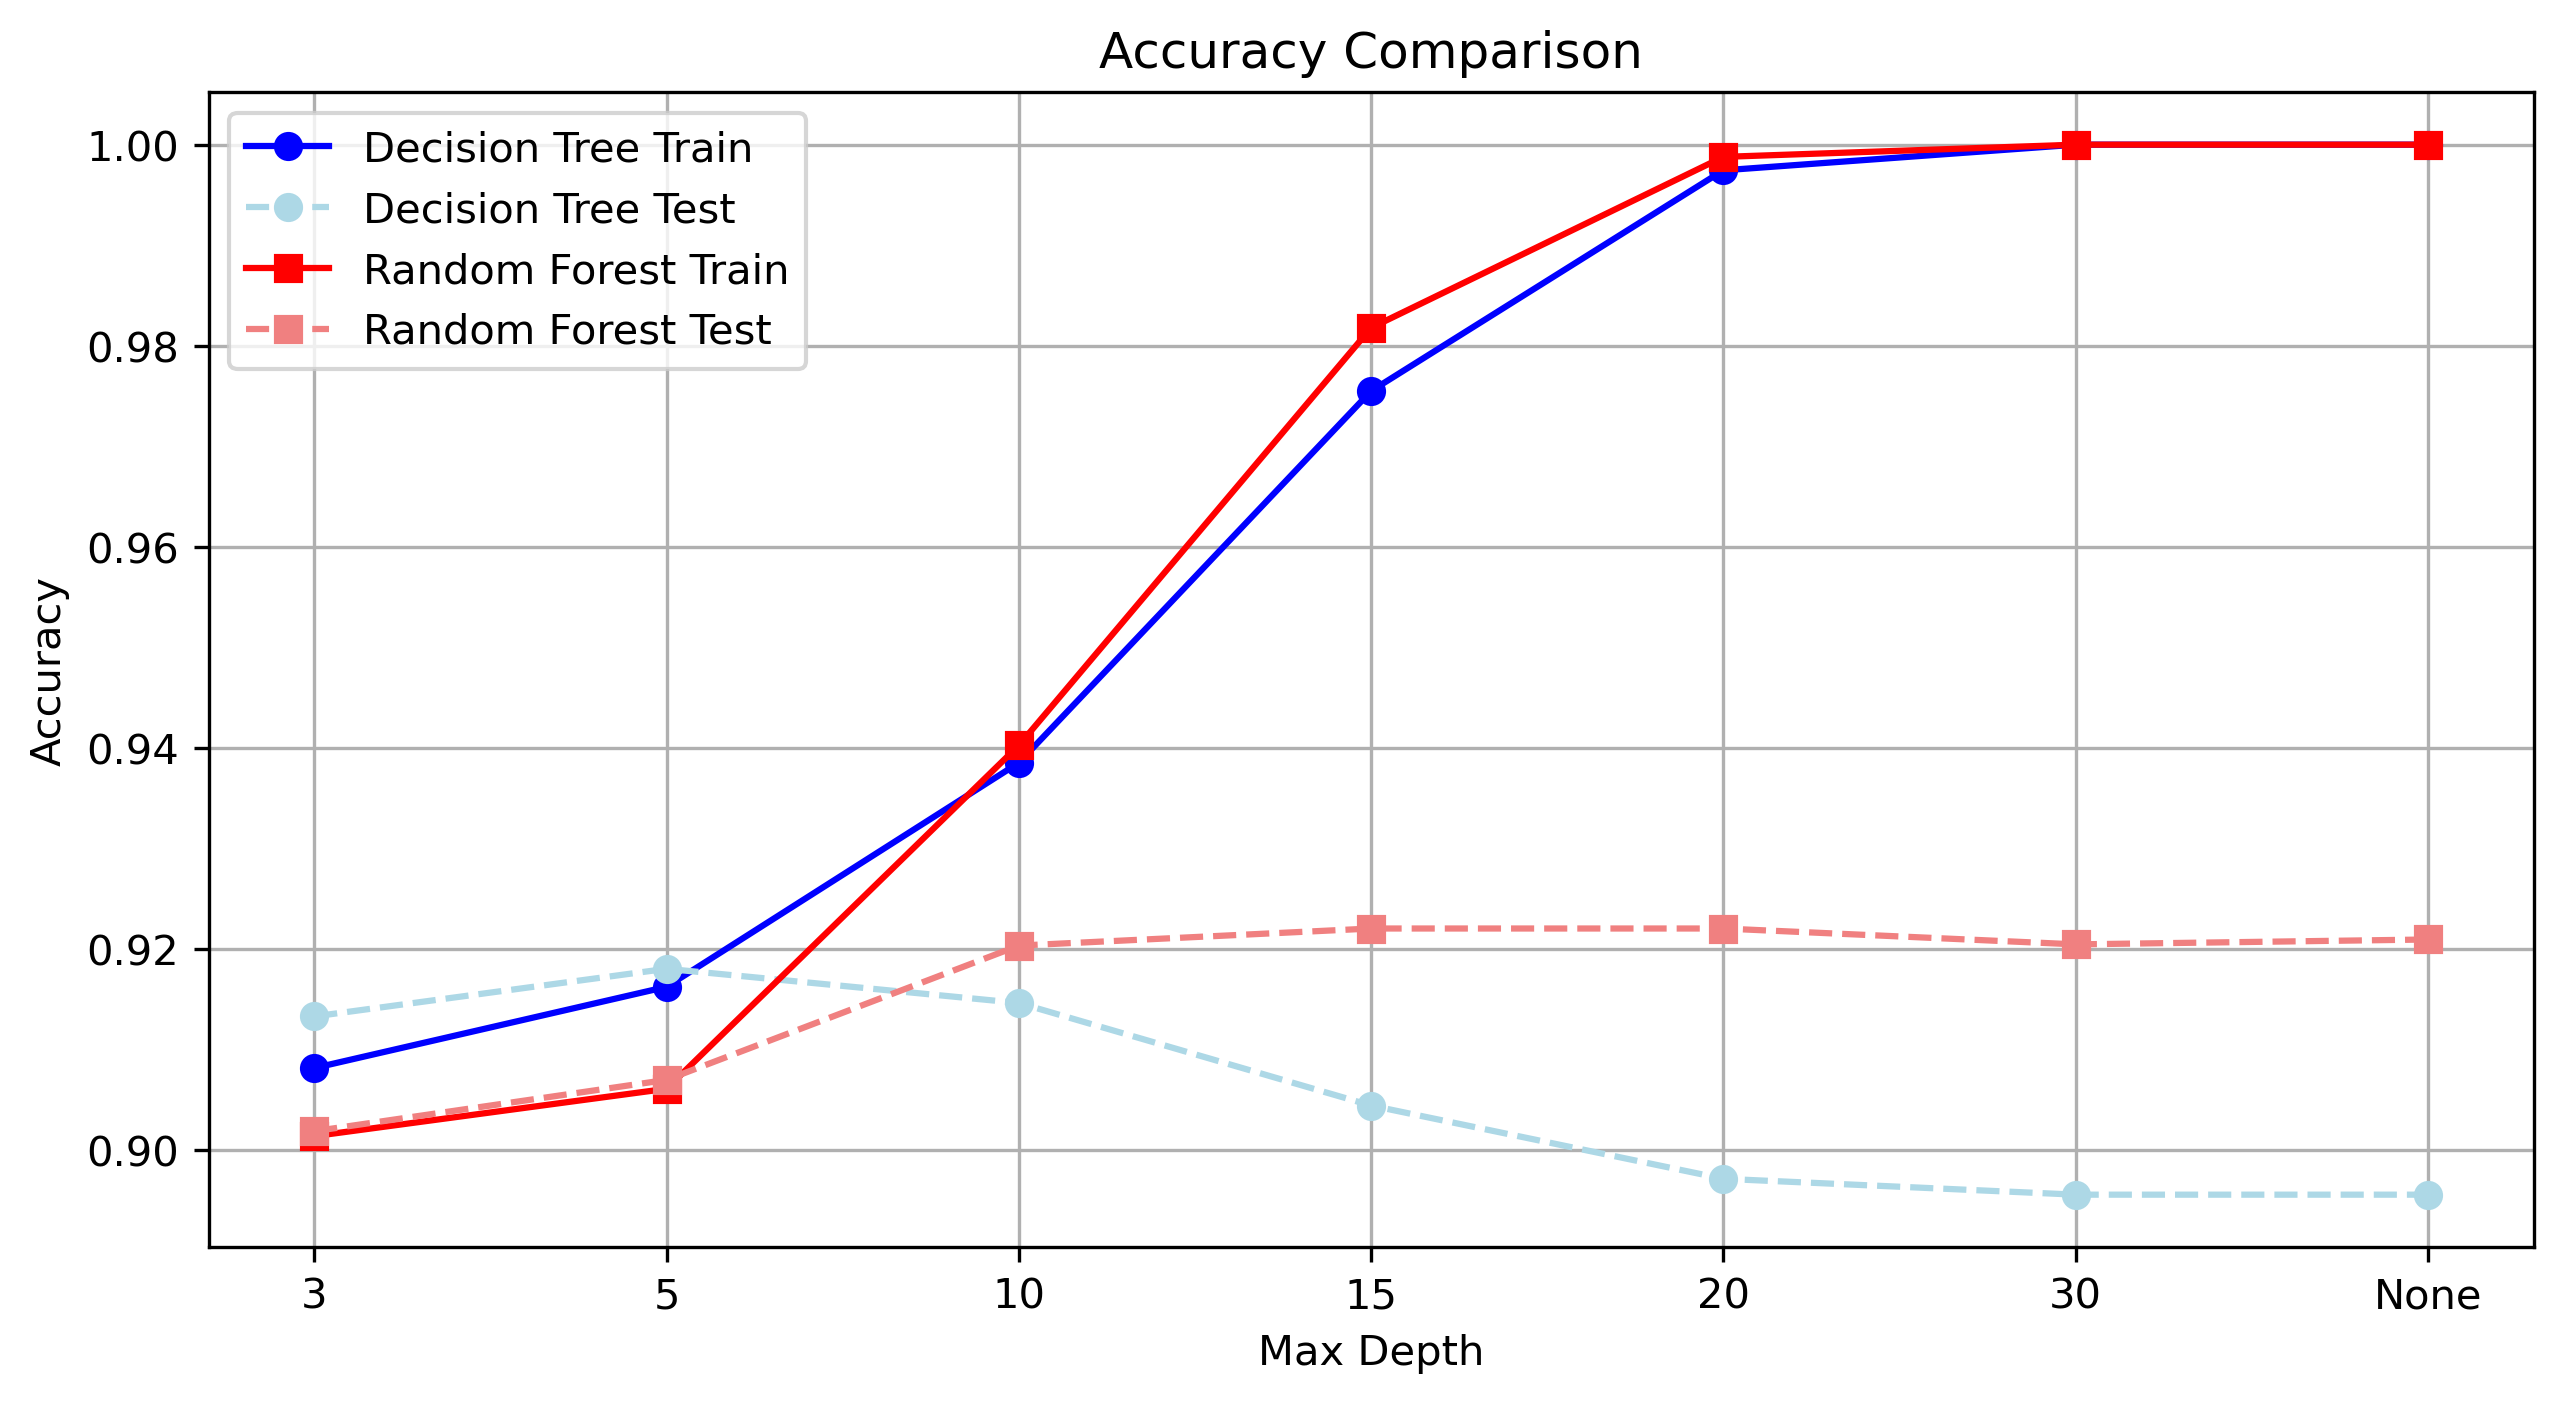

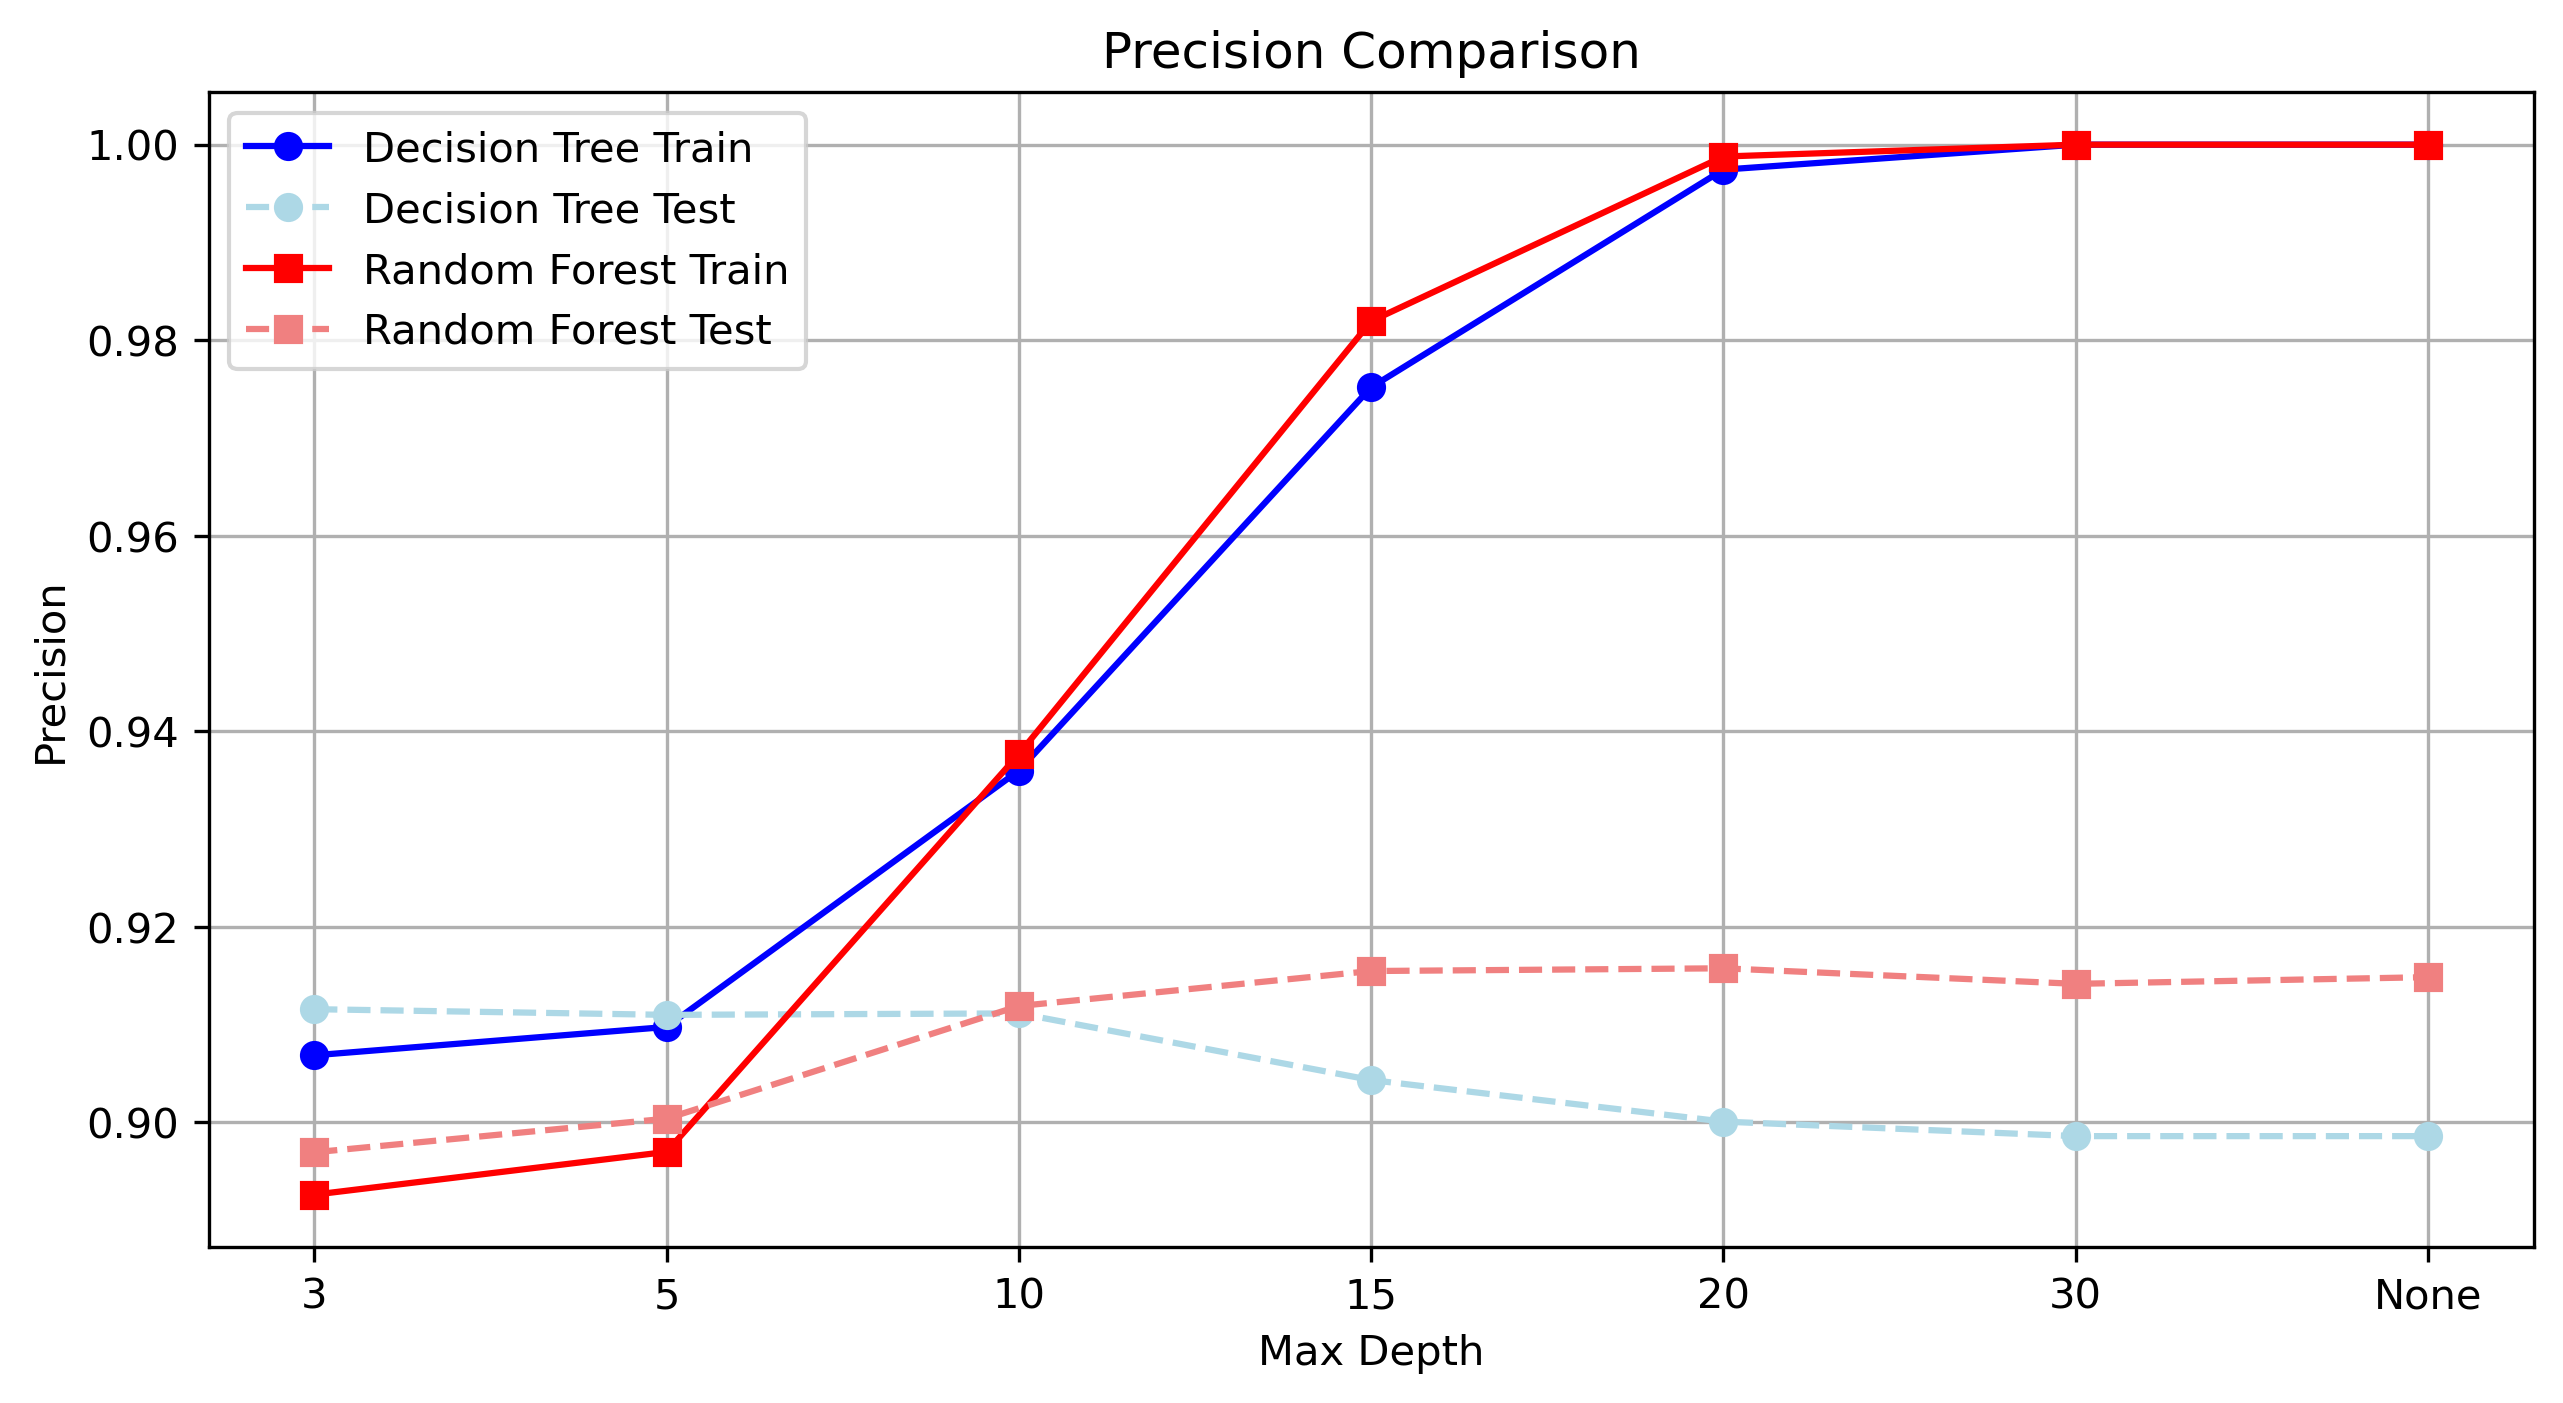

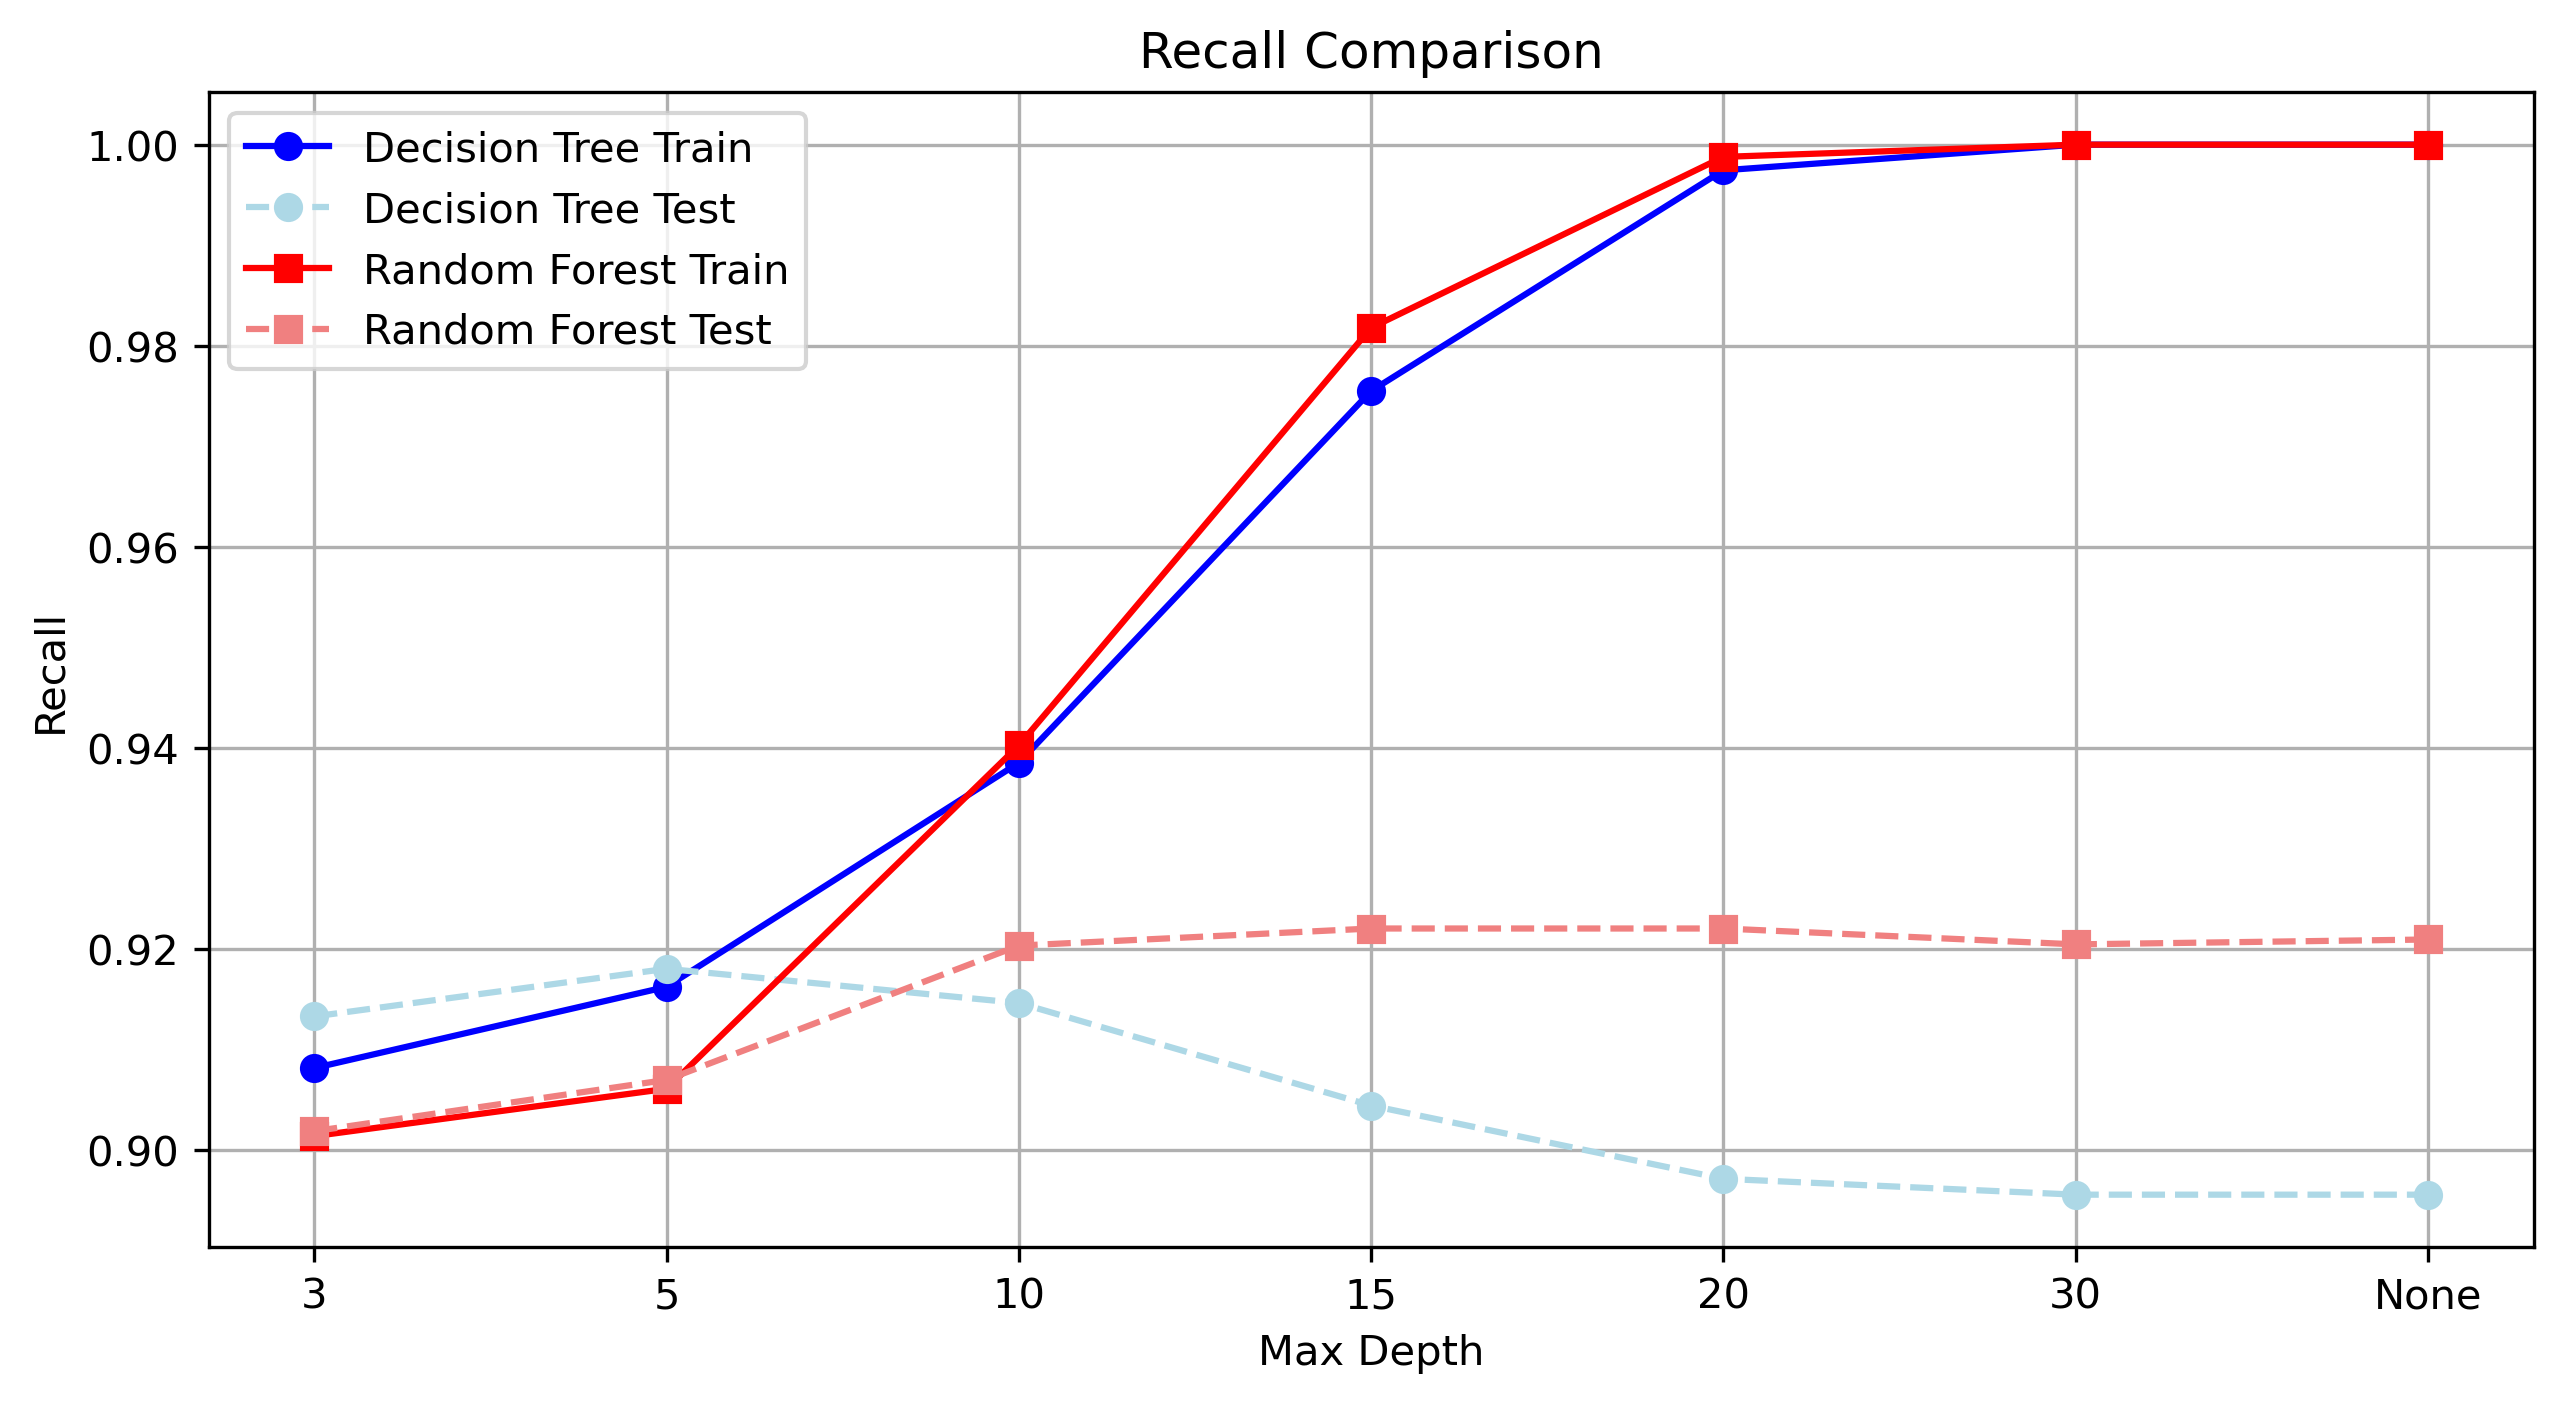

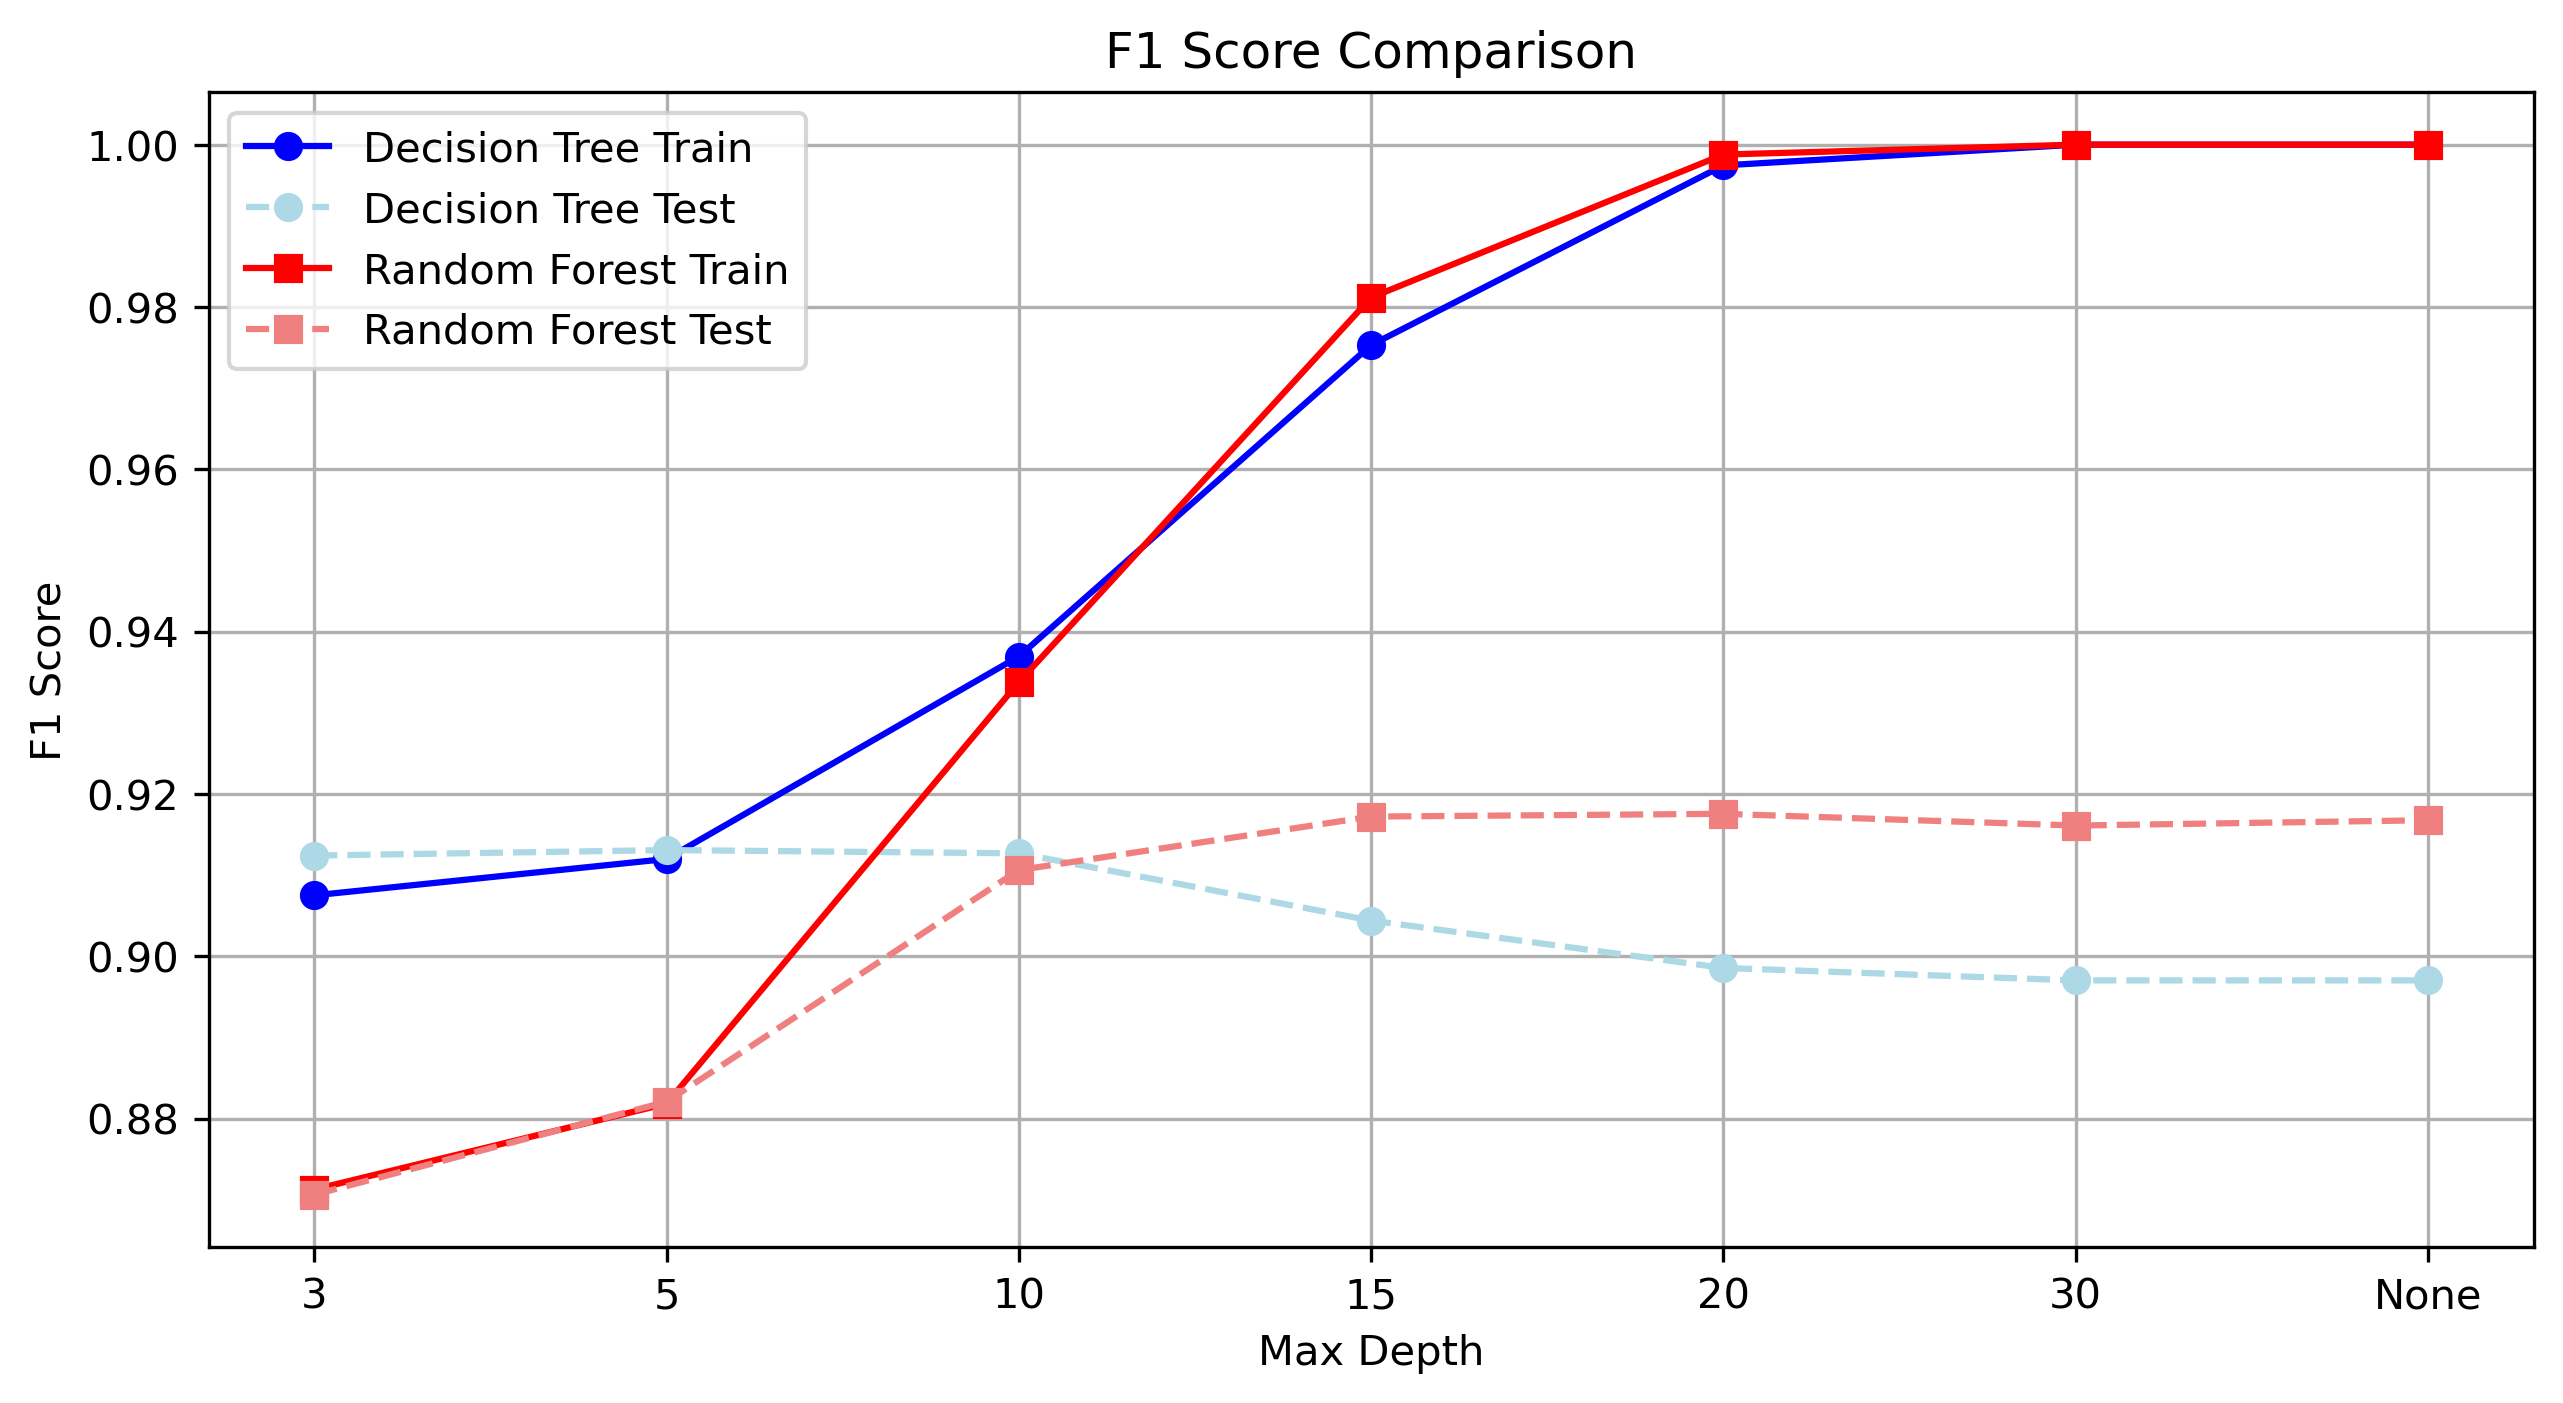


不同深度下的模型表现比较：

最大深度: 3
决策树:
训练集准确率: 0.9082
测试集准确率: 0.9133
过拟合程度: -0.0051

决策树训练集分类报告:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29238
           1       0.60      0.58      0.59      3712

    accuracy                           0.91     32950
   macro avg       0.77      0.76      0.77     32950
weighted avg       0.91      0.91      0.91     32950


决策树测试集分类报告:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7310
           1       0.62      0.59      0.61       928

    accuracy                           0.91      8238
   macro avg       0.78      0.77      0.78      8238
weighted avg       0.91      0.91      0.91      8238


随机森林:
训练集准确率: 0.9014
测试集准确率: 0.9019
过拟合程度: -0.0005

随机森林训练集分类报告:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     29238
           1       0.81      0.16      0.27      3712

    accuracy    

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 假设已经有 X_train, y_train, X_test, y_test
# 这里需要确保数据已经正确加载和划分
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建不同深度的决策树和随机森林
max_depths = [3, 5, 10, 15, 20, 30, None]  # None表示不限制深度
results = {
    'max_depth': [],
    'dt_train_accuracy': [],
    'dt_test_accuracy': [],
    'rf_train_accuracy': [],
    'rf_test_accuracy': [],
    'dt_model': [],  # 存储训练好的决策树模型
    'rf_model': [],  # 存储训练好的随机森林模型
    'dt_train_precision': [],
    'dt_test_precision': [],
    'dt_train_recall': [],
    'dt_test_recall': [],
    'dt_train_f1': [],
    'dt_test_f1': [],
    'rf_train_precision': [],
    'rf_test_precision': [],
    'rf_train_recall': [],
    'rf_test_recall': [],
    'rf_train_f1': [],
    'rf_test_f1': []
}

# 测试不同深度的决策树和随机森林
for depth in max_depths:
    # 存储当前深度
    results['max_depth'].append(str(depth))

    # 决策树
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)  # 只训练一次

    # 在训练集和测试集上预测
    y_train_pred_dt = dt.predict(X_train)
    y_test_pred_dt = dt.predict(X_test)

    # 在训练集和测试集上评估准确率
    dt_train_accuracy = dt.score(X_train, y_train)
    dt_test_accuracy = dt.score(X_test, y_test)

    # 计算决策树在训练集和测试集的精确率、召回率和F1Score
    dt_train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
    dt_test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')
    dt_train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
    dt_test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')
    dt_train_f1 = f1_score(y_train, y_train_pred_dt, average='weighted')
    dt_test_f1 = f1_score(y_test, y_test_pred_dt, average='weighted')

    # 存储决策树结果
    results['dt_train_accuracy'].append(dt_train_accuracy)
    results['dt_test_accuracy'].append(dt_test_accuracy)
    results['dt_model'].append(dt)
    results['dt_train_precision'].append(dt_train_precision)
    results['dt_test_precision'].append(dt_test_precision)
    results['dt_train_recall'].append(dt_train_recall)
    results['dt_test_recall'].append(dt_test_recall)
    results['dt_train_f1'].append(dt_train_f1)
    results['dt_test_f1'].append(dt_test_f1)

    # 随机森林
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=depth,
        random_state=42
    )
    rf.fit(X_train, y_train)  # 只训练一次

    # 在训练集和测试集上预测
    y_train_pred_rf = rf.predict(X_train)
    y_test_pred_rf = rf.predict(X_test)

    # 在训练集和测试集上评估准确率
    rf_train_accuracy = rf.score(X_train, y_train)
    rf_test_accuracy = rf.score(X_test, y_test)

    # 计算随机森林在训练集和测试集的精确率、召回率和F1Score
    rf_train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
    rf_test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')
    rf_train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
    rf_test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')
    rf_train_f1 = f1_score(y_train, y_train_pred_rf, average='weighted')
    rf_test_f1 = f1_score(y_test, y_test_pred_rf, average='weighted')

    # 存储随机森林结果
    results['rf_train_accuracy'].append(rf_train_accuracy)
    results['rf_test_accuracy'].append(rf_test_accuracy)
    results['rf_model'].append(rf)
    results['rf_train_precision'].append(rf_train_precision)
    results['rf_test_precision'].append(rf_test_precision)
    results['rf_train_recall'].append(rf_train_recall)
    results['rf_test_recall'].append(rf_test_recall)
    results['rf_train_f1'].append(rf_train_f1)
    results['rf_test_f1'].append(rf_test_f1)

# 可视化每个指标
metrics = [
    ('Accuracy', 'dt_train_accuracy', 'dt_test_accuracy', 'rf_train_accuracy', 'rf_test_accuracy'),
    ('Precision', 'dt_train_precision', 'dt_test_precision', 'rf_train_precision', 'rf_test_precision'),
    ('Recall', 'dt_train_recall', 'dt_test_recall', 'rf_train_recall', 'rf_test_recall'),
    ('F1 Score', 'dt_train_f1', 'dt_test_f1', 'rf_train_f1', 'rf_test_f1')
]

for metric_name, *metric_keys in metrics:
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(results['max_depth'], results[metric_keys[0]], 'o-', label='Decision Tree Train', color='blue')
    plt.plot(results['max_depth'], results[metric_keys[1]], 'o--', label='Decision Tree Test', color='lightblue')
    plt.plot(results['max_depth'], results[metric_keys[2]], 's-', label='Random Forest Train', color='red')
    plt.plot(results['max_depth'], results[metric_keys[3]], 's--', label='Random Forest Test', color='lightcoral')
    plt.title(f'{metric_name} Comparison')
    plt.xlabel('Max Depth')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()


# 打印详细结果并分析过拟合
print("\n不同深度下的模型表现比较：")
for i, depth in enumerate(max_depths):
    print(f"\n最大深度: {depth}")
    
    # 获取当前深度下的模型
    dt = results['dt_model'][i]
    rf = results['rf_model'][i]
    
    print("决策树:")
    print(f"训练集准确率: {results['dt_train_accuracy'][i]:.4f}")
    print(f"测试集准确率: {results['dt_test_accuracy'][i]:.4f}")
    print(f"过拟合程度: {results['dt_train_accuracy'][i] - results['dt_test_accuracy'][i]:.4f}")
    
    # 输出详细的分类报告
    y_train_pred_dt = dt.predict(X_train)
    y_test_pred_dt = dt.predict(X_test)
    print("\n决策树训练集分类报告:")
    print(classification_report(y_train, y_train_pred_dt))
    print("\n决策树测试集分类报告:")
    print(classification_report(y_test, y_test_pred_dt))
    
    print("\n随机森林:")
    print(f"训练集准确率: {results['rf_train_accuracy'][i]:.4f}")
    print(f"测试集准确率: {results['rf_test_accuracy'][i]:.4f}")
    print(f"过拟合程度: {results['rf_train_accuracy'][i] - results['rf_test_accuracy'][i]:.4f}")
    
    # 输出详细的分类报告
    y_train_pred_rf = rf.predict(X_train)
    y_test_pred_rf = rf.predict(X_test)
    print("\n随机森林训练集分类报告:")
    print(classification_report(y_train, y_train_pred_rf))
    print("\n随机森林测试集分类报告:")
    print(classification_report(y_test, y_test_pred_rf))
    
    print("-"*50)

## 重复树

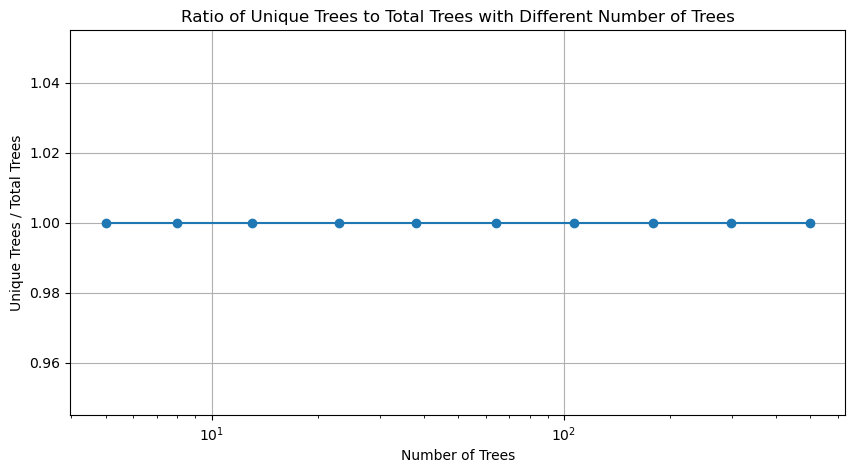

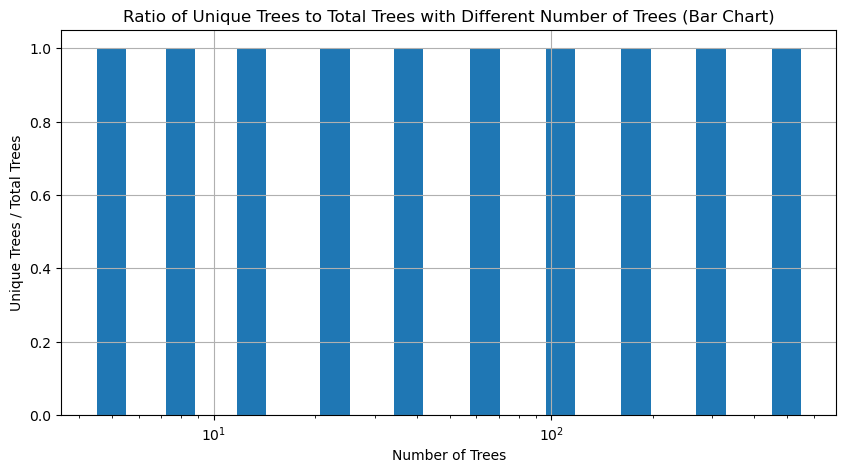

总树数: 100
唯一树数: 100
重复树数: 0

重复树的索引对:


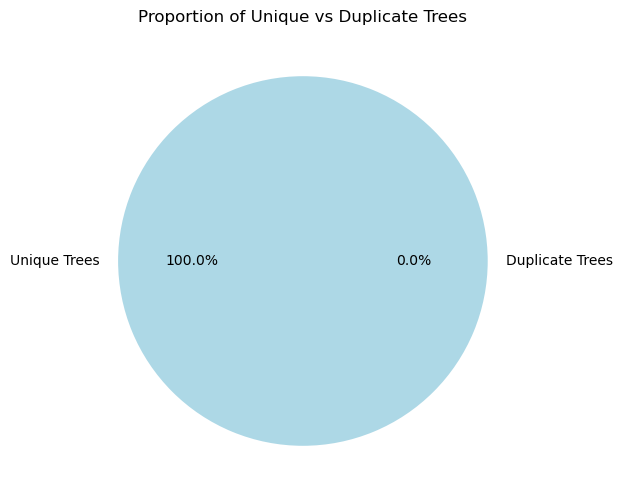

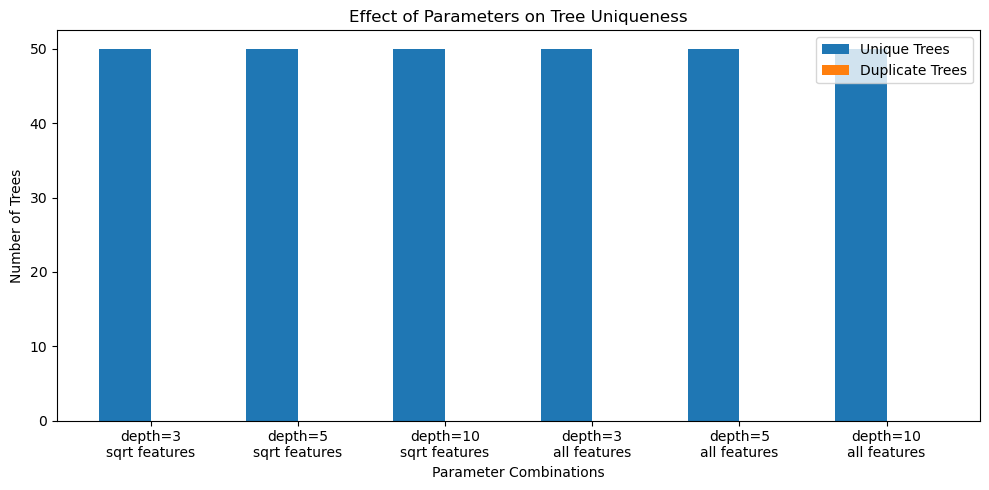


参数对树重复性的影响分析：

max_depth=3, max_features=sqrt:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%

max_depth=5, max_features=sqrt:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%

max_depth=10, max_features=sqrt:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%

max_depth=3, max_features=all:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%

max_depth=5, max_features=all:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%

max_depth=10, max_features=all:
唯一树数: 50
重复树数: 0
重复树比例: 0.0%


In [26]:
from sklearn.tree import export_text
import hashlib
# ... existing code ...

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 定义树的数量，从 5 到 1000 指数增长
n_estimators_values = np.unique(np.geomspace(5, 500, 10).astype(int))
seeds = np.arange(5)

ratios = []

for n_estimators in n_estimators_values:
    unique_tree_counts = []
    for seed in seeds:
        # 创建随机森林模型，抽样比例为 0.8
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_samples=0.8,
            random_state=seed
        )
        rf.fit(X_train, y_train)

        # 检测重复树
        duplicates, unique_trees = check_duplicate_trees(rf)
        unique_tree_counts.append(unique_trees)

    # 计算平均不重复树的比例
    avg_unique = np.mean(unique_tree_counts)
    ratio = avg_unique / n_estimators
    ratios.append(ratio)

# 绘制折线图
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, ratios, marker='o', linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Unique Trees / Total Trees')
plt.title('Ratio of Unique Trees to Total Trees with Different Number of Trees')
plt.grid(True)
plt.xscale('log')  # 使用对数刻度以便更好展示指数增长
plt.show()

# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.bar(n_estimators_values, ratios, width=[i * 0.2 for i in n_estimators_values])
plt.xlabel('Number of Trees')
plt.ylabel('Unique Trees / Total Trees')
plt.title('Ratio of Unique Trees to Total Trees with Different Number of Trees (Bar Chart)')
plt.grid(True)
plt.xscale('log')  # 使用对数刻度以便更好展示指数增长
plt.show()

# ... existing code ...
def get_tree_structure(tree):
    """获取树的结构并返回其哈希值"""
    tree_str = export_text(tree, feature_names=list(X.columns))
    return hashlib.md5(tree_str.encode()).hexdigest()

def check_duplicate_trees(rf_model):
    """检查随机森林中的重复树"""
    tree_structures = {}
    duplicates = []
    
    # 遍历所有树
    for idx, tree in enumerate(rf_model.estimators_):
        tree_hash = get_tree_structure(tree)
        
        # 如果这个结构已经存在，说明找到了重复树
        if tree_hash in tree_structures:
            duplicates.append((idx, tree_structures[tree_hash]))
        else:
            tree_structures[tree_hash] = idx
    
    return duplicates, len(tree_structures)

# 创建一个随机森林模型进行测试
rf = RandomForestClassifier(
    n_estimators=100,  
    max_depth=5,      
    random_state=42
)
rf.fit(X_train, y_train)

# 检测重复树
duplicates, unique_trees = check_duplicate_trees(rf)

# 输出结果
print(f"总树数: {len(rf.estimators_)}")
print(f"唯一树数: {unique_trees}")
print(f"重复树数: {len(rf.estimators_) - unique_trees}")
print("\n重复树的索引对:")
for dup in duplicates:
    print(f"树 {dup[0]} 与树 {dup[1]} 结构相同")

# 可视化重复树比例
plt.figure(figsize=(6, 6))
plt.pie([unique_trees, len(rf.estimators_) - unique_trees], 
        labels=['Unique Trees', 'Duplicate Trees'],
        autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Unique vs Duplicate Trees')
plt.show()

# 研究不同参数对重复树的影响
param_combinations = [
    {'n_estimators': 50, 'max_depth': 3, 'max_features': 'sqrt'},
    {'n_estimators': 50, 'max_depth': 5, 'max_features': 'sqrt'},
    {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'},
    {'n_estimators': 50, 'max_depth': 3, 'max_features': None},
    {'n_estimators': 50, 'max_depth': 5, 'max_features': None},
    {'n_estimators': 50, 'max_depth': 10, 'max_features': None},
]

results = []
for params in param_combinations:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    duplicates, unique_trees = check_duplicate_trees(rf)
    
    results.append({
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'unique_trees': unique_trees,
        'duplicate_trees': params['n_estimators'] - unique_trees
    })

# 将结果转换为DataFrame并可视化
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))

x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['unique_trees'], width, label='Unique Trees')
plt.bar(x + width/2, results_df['duplicate_trees'], width, label='Duplicate Trees')

plt.xlabel('Parameter Combinations')
plt.ylabel('Number of Trees')
plt.title('Effect of Parameters on Tree Uniqueness')
plt.xticks(x, [f'depth={d}\n{"all" if f is None else "sqrt"} features' 
               for d, f in zip(results_df['max_depth'], results_df['max_features'])])
plt.legend()
plt.tight_layout()
plt.show()

# 输出详细的参数影响分析
print("\n参数对树重复性的影响分析：")
for idx, row in results_df.iterrows():
    print(f"\nmax_depth={row['max_depth']}, max_features={'all' if row['max_features'] is None else 'sqrt'}:")
    print(f"唯一树数: {row['unique_trees']}")
    print(f"重复树数: {row['duplicate_trees']}")
    print(f"重复树比例: {row['duplicate_trees']/50*100:.1f}%")